# NHANES I Analysis

In [1]:
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
import sklearn
import matplotlib.pyplot as pl
import numpy as np
from tqdm import tqdm
import keras
import pandas as pd
import loadnhanes
import lifelines
import scipy

Using TensorFlow backend.


## Load data

In [2]:
X,y = loadnhanes._load()

# clean up a bit
for c in X.columns:
    if c.endswith("_isBlank"):
        del X[c]   
X["bmi"] = 10000 * X["weight"].values.copy() / (X["height"].values.copy() * X["height"].values.copy())
del X["weight"]
del X["height"]
del X["urine_hematest_isTrace"] # would have no variance in the strain set
del X["SGOT_isBlankbutapplicable"] # would have no variance in the strain set
del X["calcium_isBlankbutapplicable"] # would have no variance in the strain set
del X["uric_acid_isBlankbutapplicable"] # would only have one true value in the train set
del X["urine_hematest_isVerylarge"] # would only have one true value in the train set
del X["total_bilirubin_isBlankbutapplicable"] # would only have one true value in the train set
del X["alkaline_phosphatase_isBlankbutapplicable"] # would only have one true value in the train set
del X["hemoglobin_isUnacceptable"] # redundant with hematocrit_isUnacceptable
rows = np.where(np.invert(np.isnan(X["systolic_blood_pressure"]) | np.isnan(X["bmi"])))[0]
X = X.iloc[rows,:]
y = y[rows]

name_map = {
    "sex_isFemale": "Sex",
    "age": "Age",
    "systolic_blood_pressure": "Systolic blood pressure",
    "bmi": "BMI",
    "white_blood_cells": "White blood cells", # (mg/dL)
    "sedimentation_rate": "Sedimentation rate",
    "serum_albumin": "Blood albumin",
    "alkaline_phosphatase": "Alkaline phosphatase",
    "cholesterol": "Total cholesterol",
    "physical_activity": "Physical activity",
    "hematocrit": "Hematocrit",
    "uric_acid": "Uric acid",
    "red_blood_cells": "Red blood cells",
    "urine_albumin_isNegative": "Albumin present in urine",
    "serum_protein": "Blood protein"
}
mapped_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))

# split by patient id
pids = np.unique(X.index.values)
train_pids,test_pids = train_test_split(pids, random_state=0)
strain_pids,valid_pids = train_test_split(train_pids, random_state=0)

# find the indexes of the samples from the patient ids
train_inds = np.where([p in train_pids for p in X.index.values])[0]
strain_inds = np.where([p in strain_pids for p in X.index.values])[0]
valid_inds = np.where([p in valid_pids for p in X.index.values])[0]
test_inds = np.where([p in test_pids for p in X.index.values])[0]

# create the split datasets
X_train = X.iloc[train_inds,:]
X_strain = X.iloc[strain_inds,:]
X_valid = X.iloc[valid_inds,:]
X_test = X.iloc[test_inds,:]
y_train = y[train_inds]
y_strain = y[strain_inds]
y_valid = y[valid_inds]
y_test = y[test_inds]

# mean impute for linear and deep models
imp = Imputer()
imp.fit(X_strain)
X_strain_imp = imp.transform(X_strain)
X_train_imp = imp.transform(X_train)
X_valid_imp = imp.transform(X_valid)
X_test_imp = imp.transform(X_test)
X_imp = imp.transform(X)

# standardize
scaler = StandardScaler()
scaler.fit(X_strain_imp)
X_strain_imp = scaler.transform(X_strain_imp)
X_train_imp = scaler.transform(X_train_imp)
X_valid_imp = scaler.transform(X_valid_imp)
X_test_imp = scaler.transform(X_test_imp)
X_imp = scaler.transform(X_imp)

number of people surviving  9622
number of people not surviving  4785


In [4]:
X.shape

(14264, 79)

## Train XGBoost

In [3]:
# these parameters were found using the Tune XGboost on NHANES notebook (coordinate decent)
params = {
    "learning_rate": 0.001,
    "n_estimators": 6765,
    "max_depth": 4,
    "subsample": 0.5, 
    "reg_lambda": 5.5,
    "reg_alpha": 0,
    "colsample_bytree": 1
}

xgb_model = xgboost.XGBRegressor(
    max_depth=params["max_depth"],
    n_estimators=params["n_estimators"],
    learning_rate=params["learning_rate"],#math.pow(10, params["learning_rate"]),
    subsample=params["subsample"],
    reg_lambda=params["reg_lambda"],
    colsample_bytree=params["colsample_bytree"],
    reg_alpha=params["reg_alpha"],
    n_jobs=16,
    random_state=1,
    objective="survival:cox",
    base_score=1
)
xgb_model.fit(
    X_strain, y_strain, verbose=500,
    eval_set=[(X_valid, y_valid)],
    #eval_metric="logloss",
    early_stopping_rounds=10000
)

[0]	validation_0-cox-nloglik:7.62832
Will train until validation_0-cox-nloglik hasn't improved in 10000 rounds.
[500]	validation_0-cox-nloglik:7.21835
[1000]	validation_0-cox-nloglik:7.05681
[1500]	validation_0-cox-nloglik:6.97786
[2000]	validation_0-cox-nloglik:6.93528
[2500]	validation_0-cox-nloglik:6.91069
[3000]	validation_0-cox-nloglik:6.89623
[3500]	validation_0-cox-nloglik:6.88658
[4000]	validation_0-cox-nloglik:6.87973
[4500]	validation_0-cox-nloglik:6.87545
[5000]	validation_0-cox-nloglik:6.87225
[5500]	validation_0-cox-nloglik:6.87047
[6000]	validation_0-cox-nloglik:6.86934
[6500]	validation_0-cox-nloglik:6.86851
[6764]	validation_0-cox-nloglik:6.86832


XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.001, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=6765,
       n_jobs=16, nthread=None, objective='survival:cox', random_state=1,
       reg_alpha=0, reg_lambda=5.5, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [5]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [6]:
c_statistic_harrell(xgb_model.predict(X_test), y_test)

0.821366174285336

## Linear model

### Choose L2 regularizer

In [8]:
tmp = pd.DataFrame(X_strain_imp)
tmp["T"] = np.abs(y_strain)
tmp["E"] = y_strain > 0
     
penalties = np.logspace(1, 3, 10)
cstats = []
for penalty in tqdm(penalties):
    cph = lifelines.CoxPHFitter(penalizer=penalty)
    cph.fit(tmp, "T", "E")
    v = c_statistic_harrell(cph.predict_log_partial_hazard(X_valid_imp).values, y_valid)
    cstats.append(v)

  0%|          | 0/10 [00:00<?, ?it/s]/home/slund1/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/slund1/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/slund1/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/slund1/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/slund1/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
 10%|█         | 1/10 [00:07<01:09,  7.75s/it]/home/slund1/anaconda3/lib/python3.5/site-p

In [9]:
print("Best penalty:", penalties[np.argmax(cstats)])

Best penalty: 215.443469003


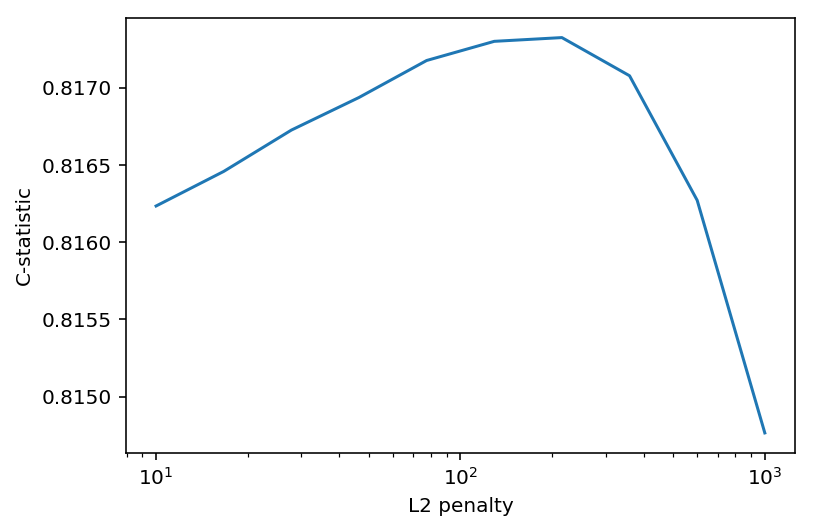

In [10]:
pl.semilogx(penalties, cstats)
pl.xlabel("L2 penalty")
pl.ylabel("C-statistic")
pl.show()

In [11]:
np.cph = lifelines.CoxPHFitter(penalizer=penalties[np.argmax(cstats)])
cph.fit(tmp, "T", "E")
c_statistic_harrell(cph.predict_log_partial_hazard(X_test_imp).values, y_test)

/home/slund1/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/slund1/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/slund1/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/slund1/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/slund1/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.8131905721726082

## Build summary plots

In [12]:
explainer = shap.TreeExplainer(xgb_model)
xgb_shap = explainer.shap_values(X)

In [256]:
np.isnan(X.values.astype(np.float64)).sum()

155779

In [41]:
xgb_shap_interaction = shap.TreeExplainer(xgb_model).shap_interaction_values(X)

In [42]:
xgb_shap_interaction.shape

(14264, 79, 79)

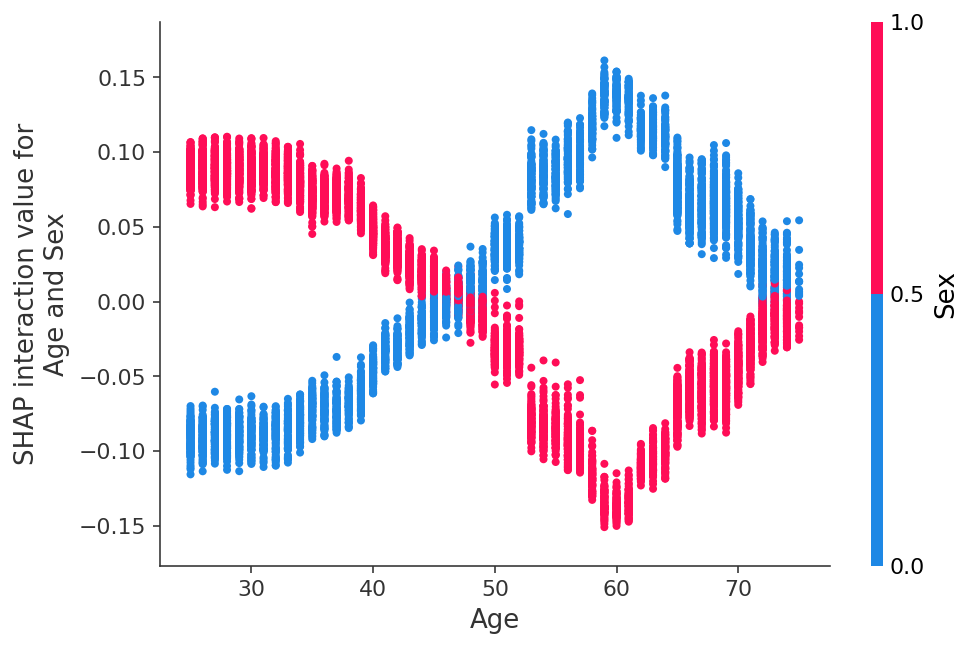

In [48]:
shap.dependence_plot(("Age", "Sex"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
pl.savefig("raw_figures/nhanes_age_sex_interaction.pdf", dpi=400)
pl.show()

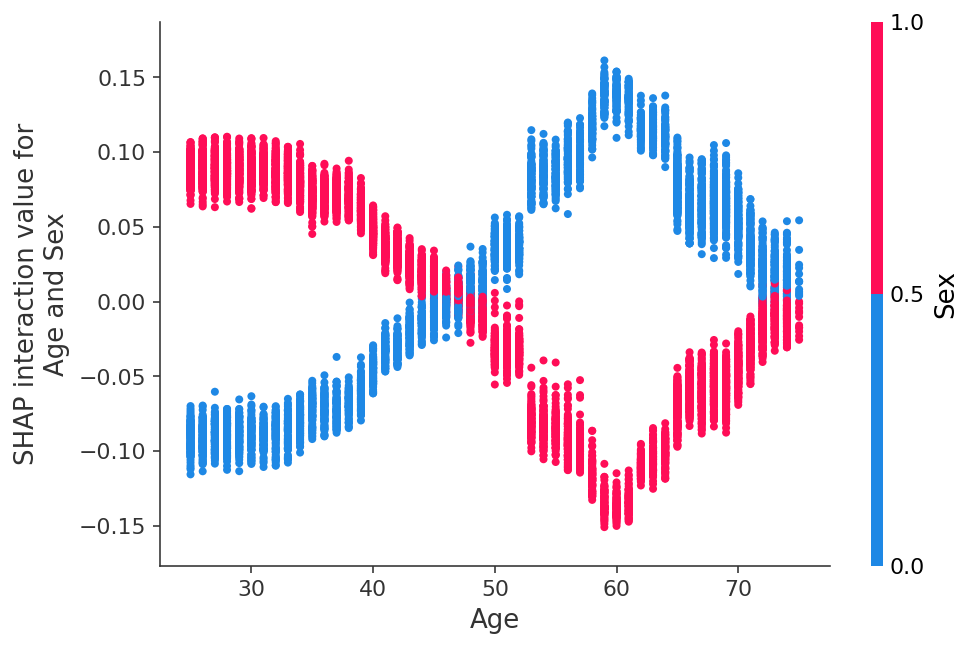

In [48]:
shap.dependence_plot(("Age", "Sex"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
pl.savefig("raw_figures/nhanes_age_sex_interaction.pdf", dpi=400)
pl.show()

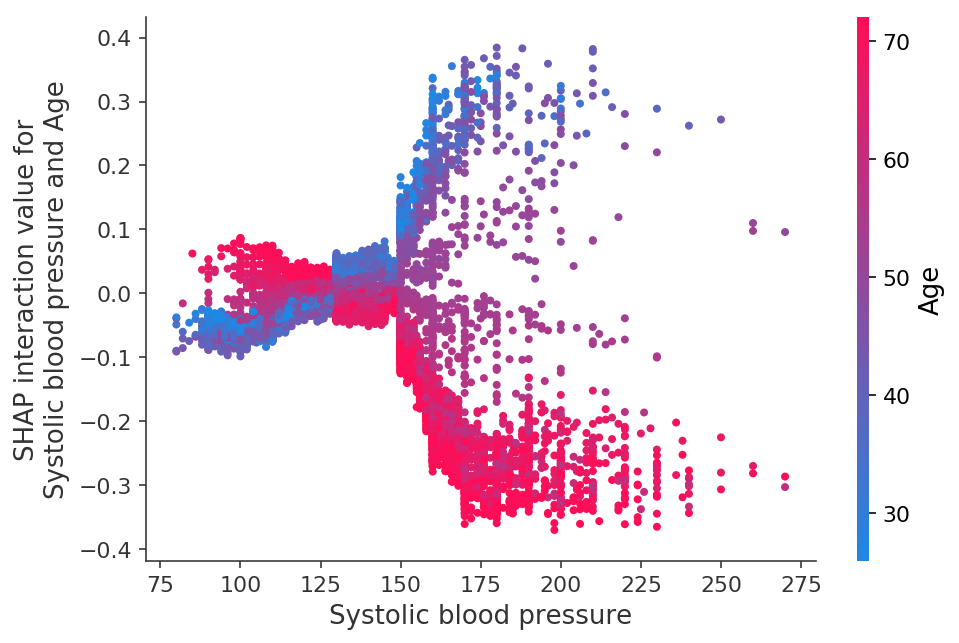

In [71]:
shap.dependence_plot(("Systolic blood pressure", "Age"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
pl.savefig("raw_figures/nhanes_sbp_age_interaction.pdf", dpi=400)
pl.show()

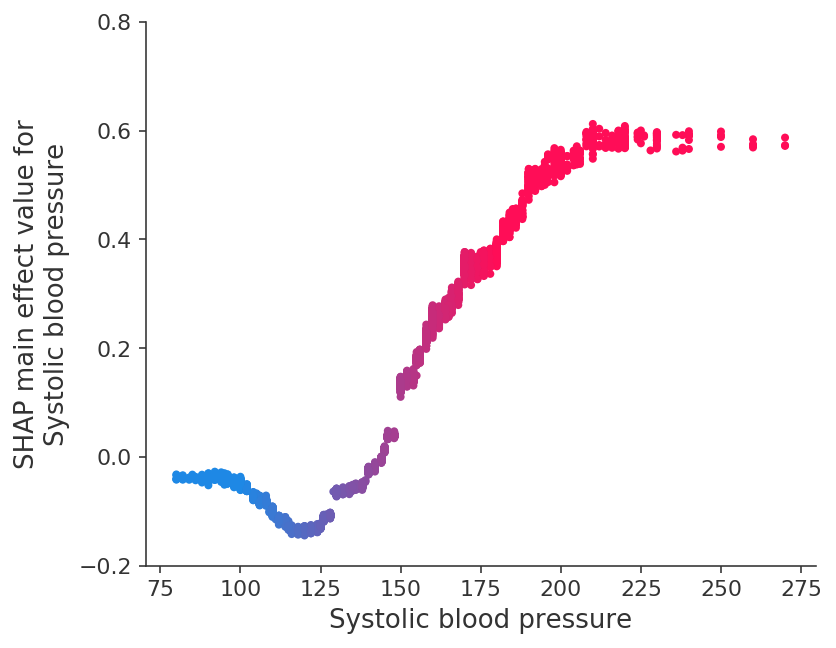

In [72]:
shap.dependence_plot(
    ("Systolic blood pressure", "Systolic blood pressure"),
    xgb_shap_interaction, X,
    feature_names=np.array(mapped_feature_names),
    show=False,
    color=shap.plots.colors.blue_rgb
)
pl.savefig("raw_figures/nhanes_sbp_main_effect.pdf", dpi=400)
pl.ylim(-0.2, 0.8)
pl.show()

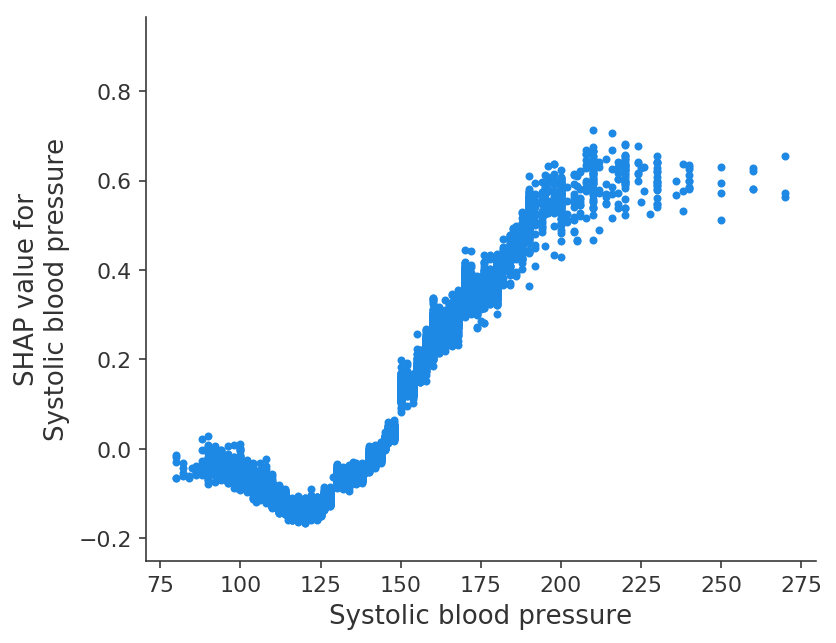

In [94]:
ind1 = np.where(np.array(mapped_feature_names) == "Age")[0][0]
ind2 = np.where(np.array(mapped_feature_names) == "Systolic blood pressure")[0][0]
shap.dependence_plot(
    0,
    (xgb_shap_interaction[:,:,ind2].sum(1) - xgb_shap_interaction[:,ind1,ind2]).reshape(X.shape[0],1), X.iloc[:,ind2:ind2+1],
    feature_names=np.array(mapped_feature_names)[ind2:ind2+1],
    show=False,
    color=shap.plots.colors.blue_rgb,
    interaction_index=None
)
pl.gcf().set_size_inches(6, 5)
pl.ylim(-0.25019020676623821, 0.96597250640403265)
pl.savefig("raw_figures/nhanes_sbp_main_effect.pdf", dpi=400)
pl.show()

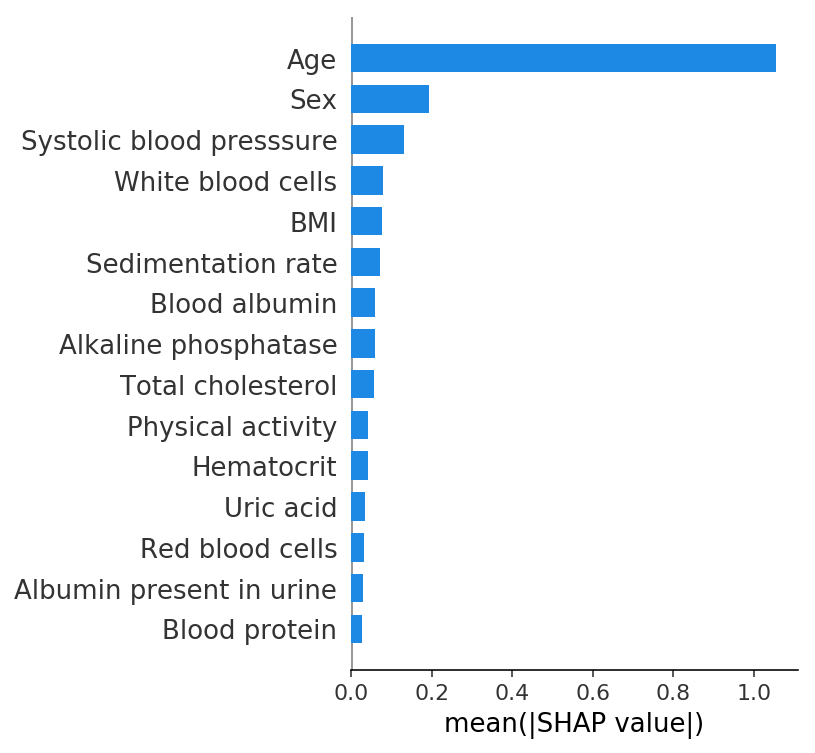

In [246]:
f = pl.figure(figsize=(4,6))
shap.summary_plot(
    xgb_shap, X, feature_names=mapped_feature_names, plot_type="bar",
    max_display=15, auto_size_plot=False, show=False
)
pl.xlabel("mean(|SHAP value|)")
pl.savefig("raw_figures/nhanes_summary_bar.pdf", dpi=400)
pl.show()

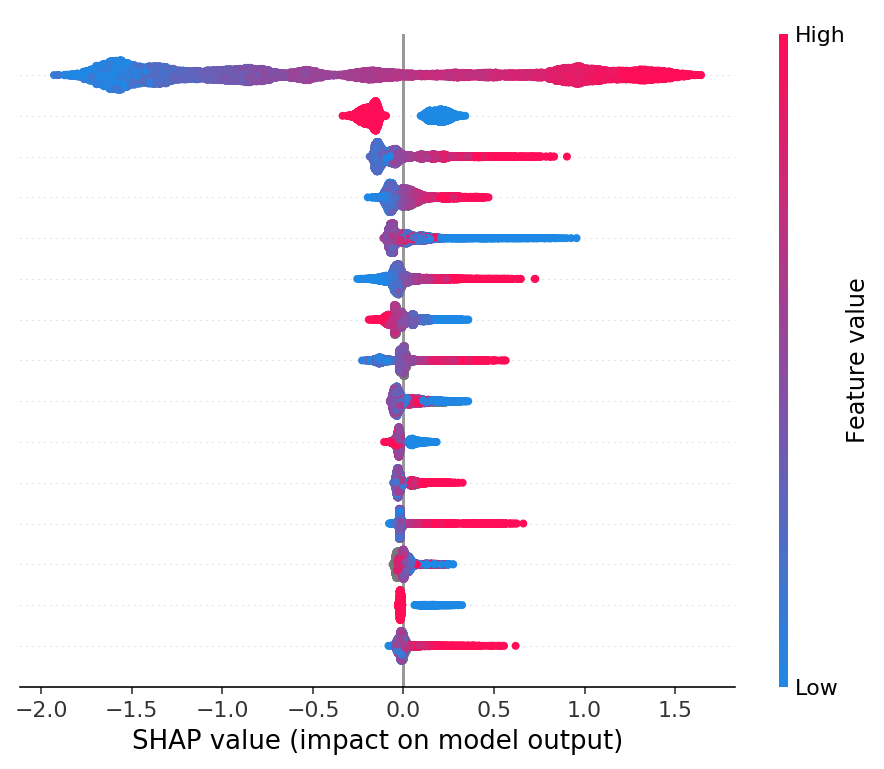

In [247]:
f = pl.figure(figsize=(8,6))
shap.summary_plot(
    xgb_shap, X, feature_names=["" for m in mapped_feature_names], plot_type="dot",
    max_display=15, auto_size_plot=False, show=False
)
pl.savefig("raw_figures/nhanes_summary_dot.pdf", dpi=400)
pl.show()

## Build embedding plots

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

np.random.seed(0)
#shap_pca = PCA(n_components=20).fit_transform(xgb_shap)
#shap_tsne = TSNE(n_components=2, perplexity=50, random_state=0).fit_transform(xgb_shap[:2000,:])
shap_pca = PCA(n_components=2).fit_transform(xgb_shap)
raw_pca = PCA(n_components=2).fit_transform(X_imp)

In [110]:
shap_pca_f = PCA(n_components=2).fit_transform(xgb_shap_f)

In [110]:
shap_pca_m = PCA(n_components=2).fit_transform(xgb_shap_m)

In [109]:
X_f = X.iloc[X["sex_isFemale"].values,:]
xgb_shap_f = xgb_shap[X["sex_isFemale"].values,:]
X_m = X.iloc[np.invert(X["sex_isFemale"].values),:]
xgb_shap_m = xgb_shap[np.invert(X["sex_isFemale"].values),:]

In [126]:
tmp = PCA(n_components=50).fit_transform(xgb_shap_f)
shap_tsne_f = TSNE(
    n_components=2, perplexity=50, random_state=0,
    n_iter=3000, n_iter_without_progress=300
).fit_transform(tmp[:5000,:])

In [55]:
tmp = PCA(n_components=30).fit_transform(xgb_shap)
shap_tsne = TSNE(
    n_components=2, perplexity=10, random_state=2,
    n_iter=5000, n_iter_without_progress=700
).fit_transform(tmp[:1000,:])

In [ ]:
tmp = PCA(n_components=50).fit_transform(xgb_shap_m)
shap_tsne_m = TSNE(
    n_components=2, perplexity=50, random_state=0,
    n_iter=3000, n_iter_without_progress=300
).fit_transform(tmp[:5000,:])

In [22]:
def embedding_plot(embedding, values, label, alpha=1.0, show=True):
    f = pl.figure(figsize=(5,5))
    pl.scatter(embedding[:,0],
               embedding[:,1],
               c=values,
               linewidth=0, alpha=alpha, cmap=shap.plots.colors.red_blue_solid)
    cb = pl.colorbar(label=label, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    pl.gca().axis("off")
    if show:
        pl.show()

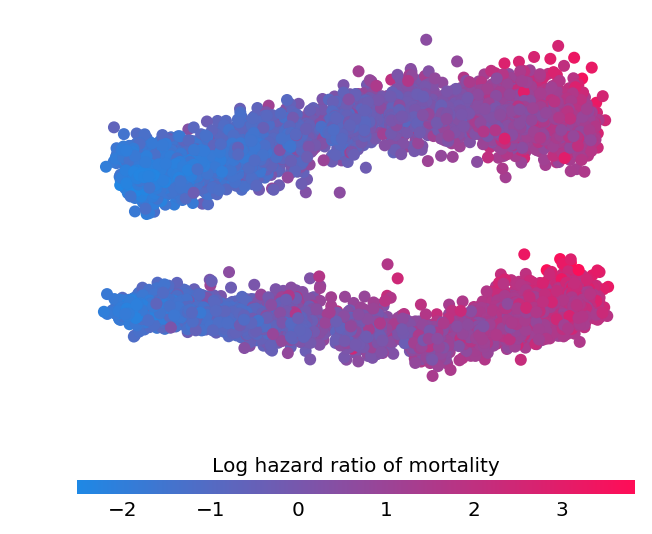

In [149]:
embedding_plot(shap_pca, xgb_shap.sum(1), "Log hazard ratio of mortality", show=False)
pl.savefig("raw_figures/nhanes_shap_pca_risk.pdf", dpi=400)
pl.show()

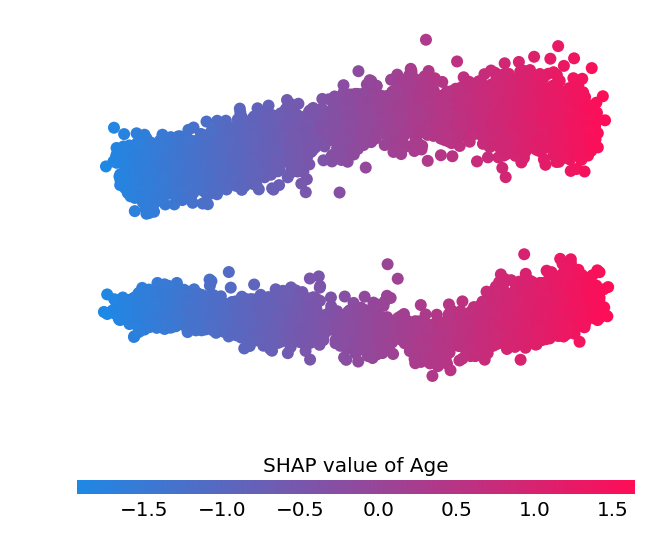

In [25]:
ind = np.where(X.columns == "age")[0][0]
embedding_plot(shap_pca, xgb_shap[:,ind], "SHAP value of "+str(mapped_feature_names[ind]), show=False)
pl.savefig("raw_figures/nhanes_shap_pca_age.pdf", dpi=400)
pl.show()

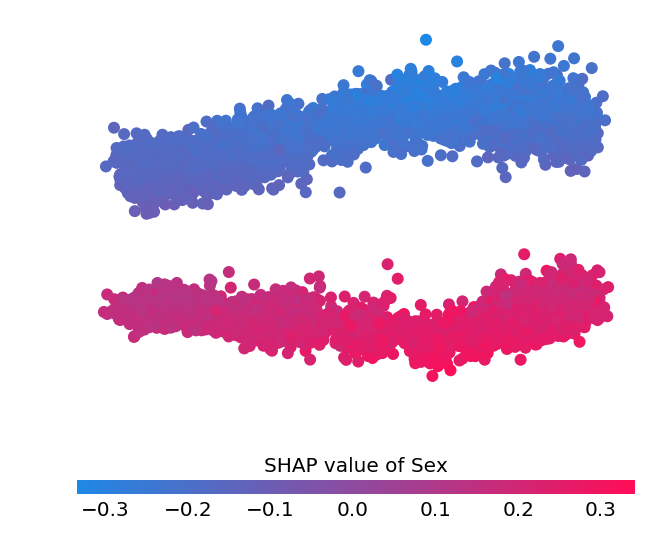

In [26]:
ind = np.where(X.columns == "sex_isFemale")[0][0]
embedding_plot(shap_pca, xgb_shap[:,ind], "SHAP value of "+str(mapped_feature_names[ind]), show=False)
pl.savefig("raw_figures/nhanes_shap_pca_sex.pdf", dpi=400)
pl.show()

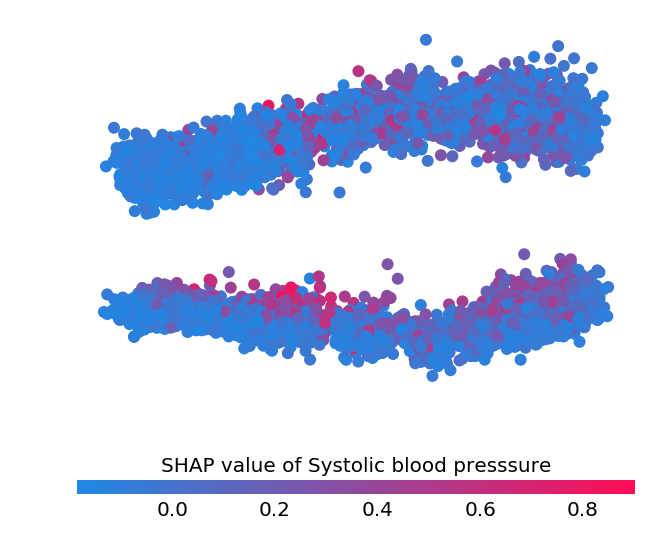

In [27]:
ind = np.where(X.columns == "systolic_blood_pressure")[0][0]
embedding_plot(shap_pca, xgb_shap[:,ind], "SHAP value of "+str(mapped_feature_names[ind]), show=False)
pl.savefig("raw_figures/nhanes_shap_pca_sbp.pdf", dpi=400)
pl.show()

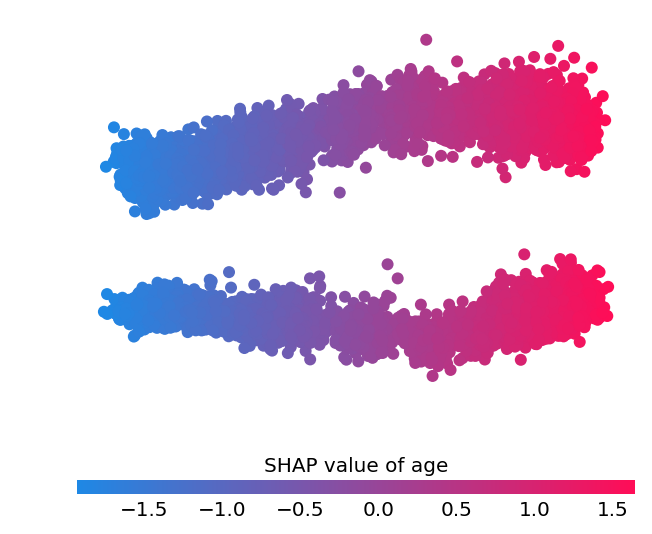

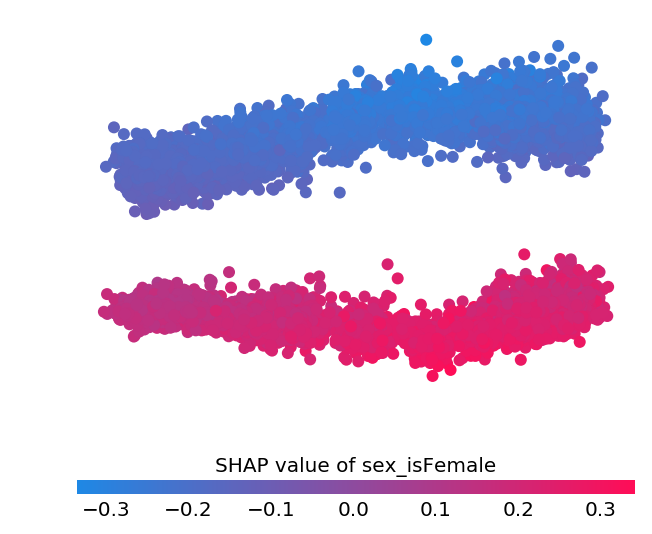

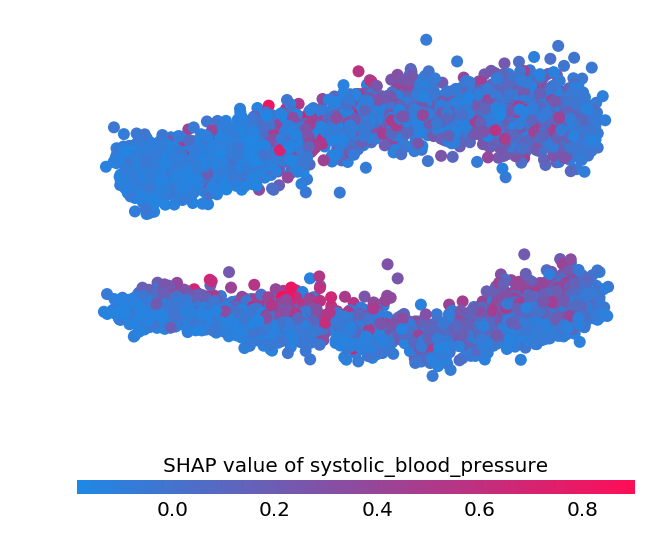

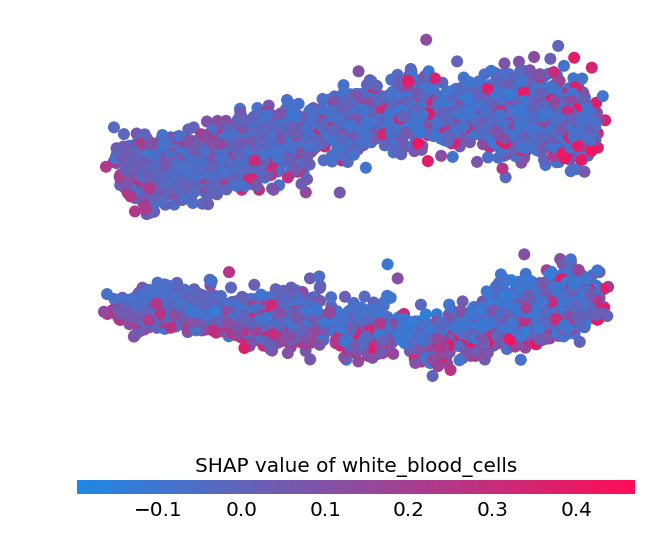

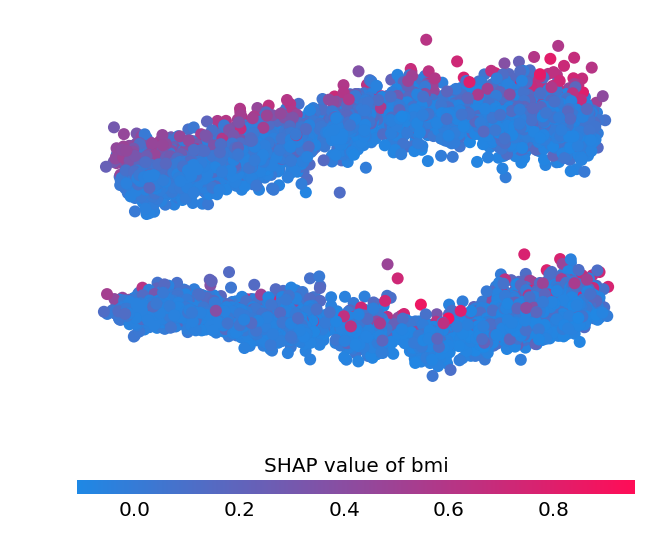

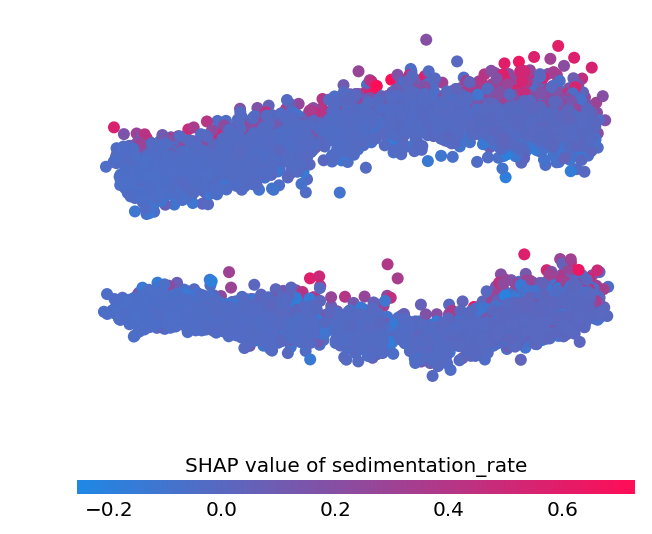

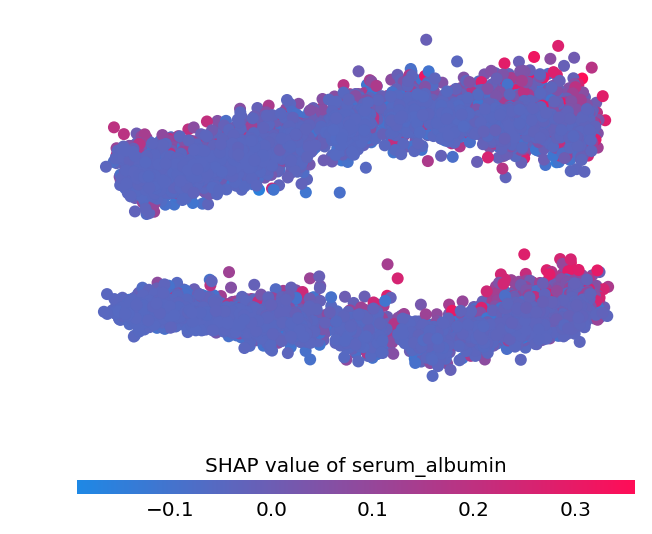

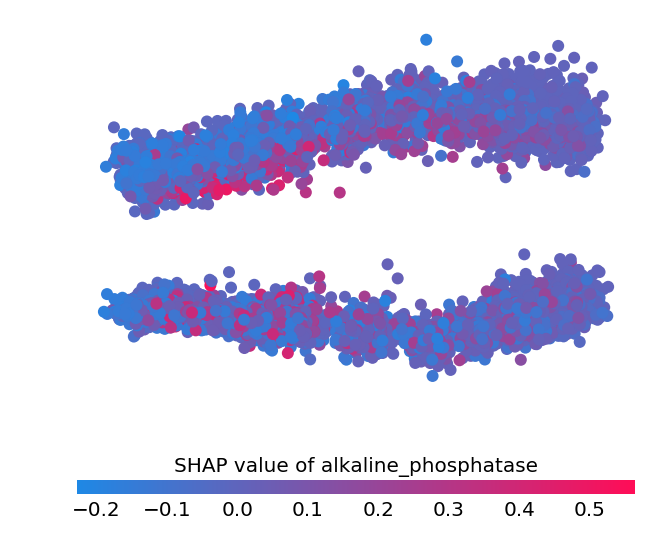

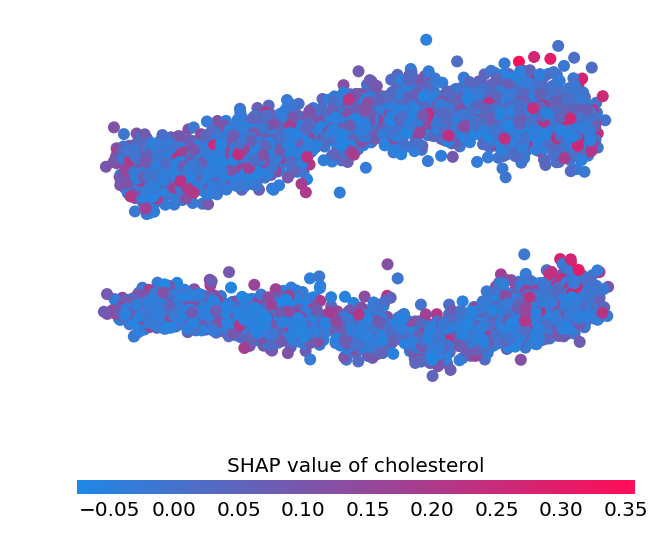

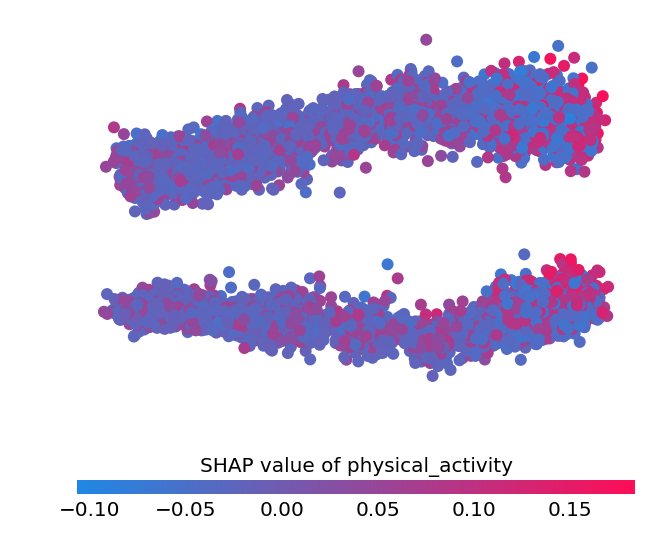

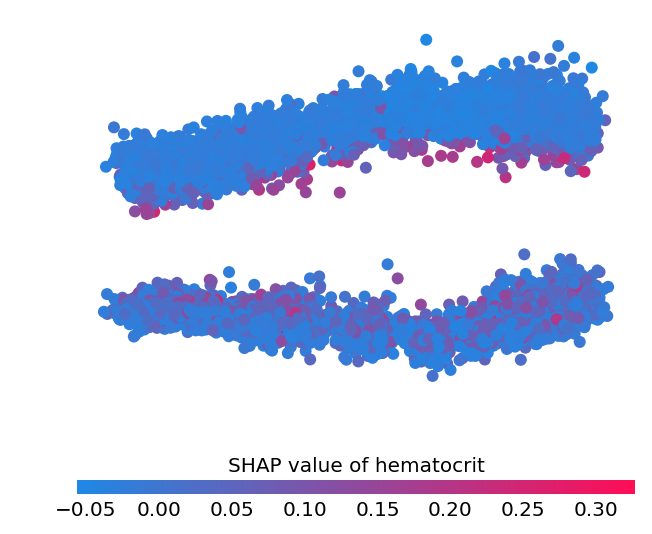

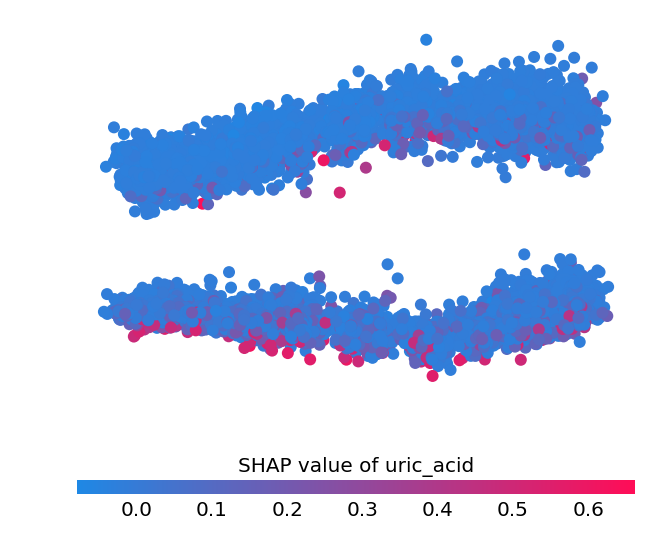

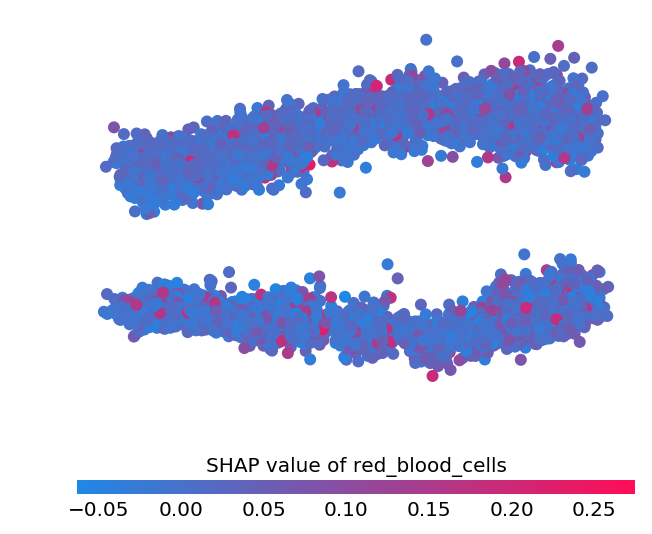

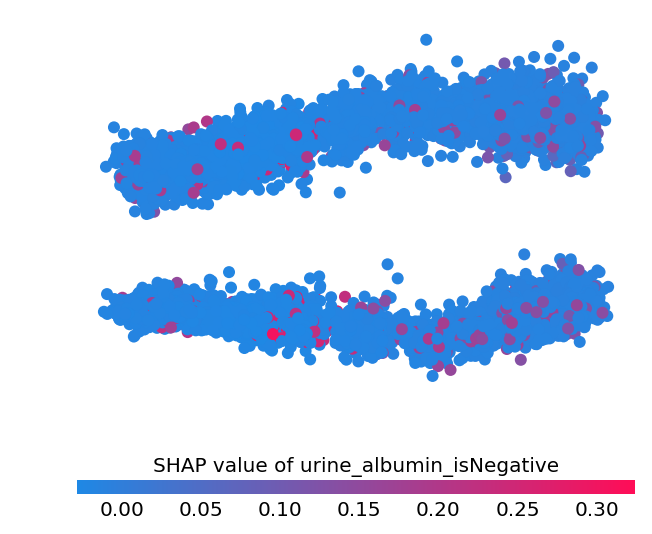

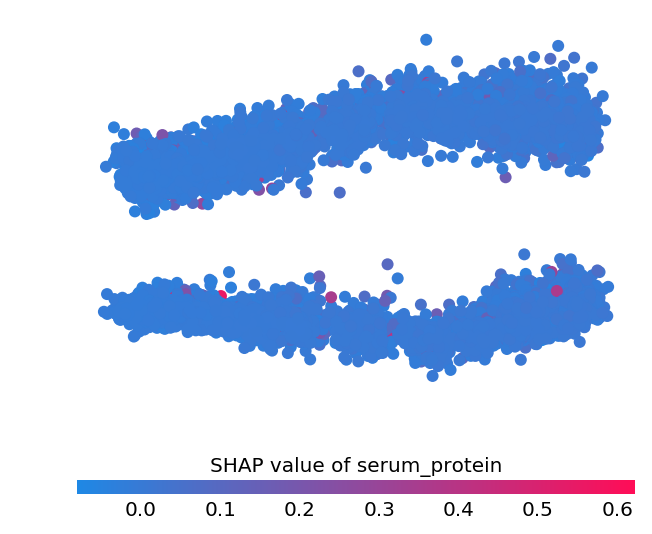

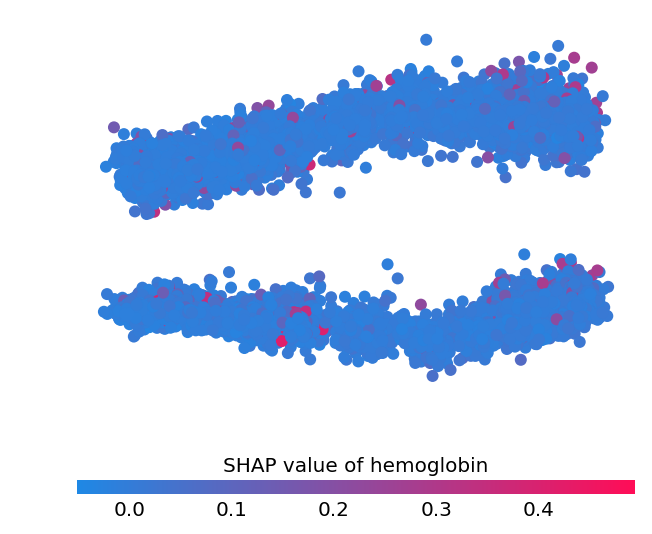

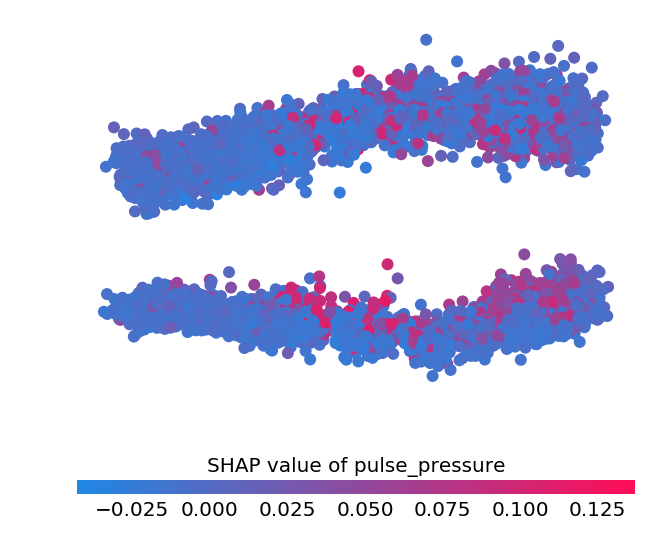

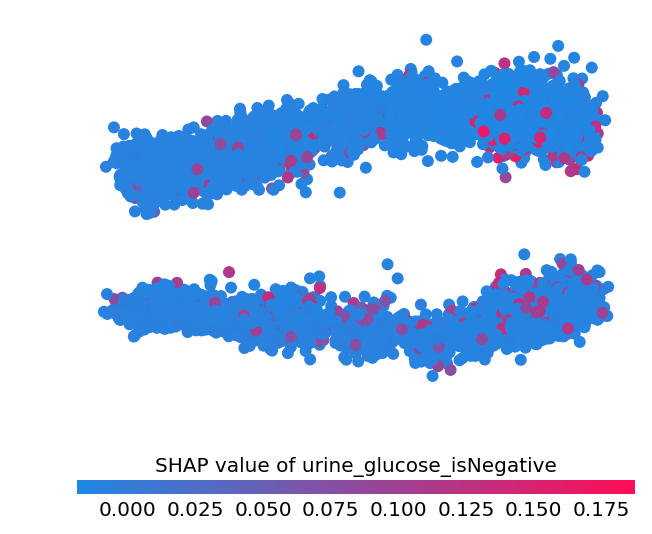

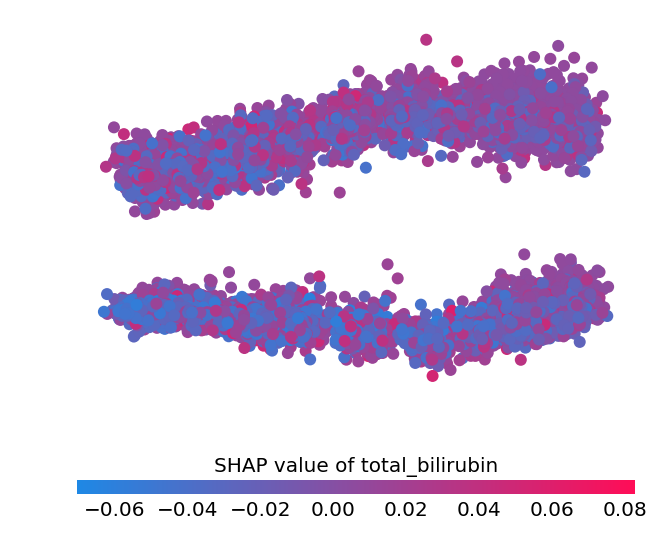

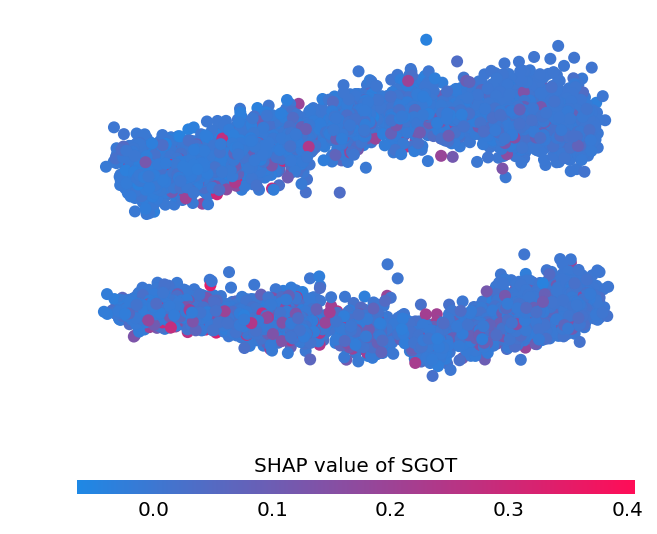

In [134]:
for i in np.argsort(-np.abs(xgb_shap).mean(0))[:20]:
    embedding_plot(shap_pca, xgb_shap[:shap_pca.shape[0],i], "SHAP value of "+str(X.columns[i]), show=False)
    #pl.savefig("raw_figures/kidney_shap_pca_risk.pdf", dpi=400)
    pl.show()

In [25]:
import scipy

D = scipy.spatial.distance.pdist(xgb_shap, 'sqeuclidean')
clustOrder = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.complete(D))

In [61]:
obj = scipy.cluster.hierarchy.complete(D)

In [62]:
obj.shape

(14263, 4)

In [64]:
obj[:1,:]

array([[  7.94100000e+03,   9.41600000e+03,   5.97964520e-04,
          2.00000000e+00]])

In [328]:
scipy.spatial.distance.pdist(xgb_shap, "sqeuclidean")

array([ 3.25810919,  0.02612914,  0.50275828, ...,  1.73628307,
        1.07333582,  3.37785861])

In [335]:
from scipy.spatial.distance import pdist
pdist(np.vstack([xgb_shap[s1[-1],:], xgb_shap[s2[0],:]]), "sqeuclidean")[0]

5.4367997662394378

In [334]:
np.sum((xgb_shap[s1[-1],:] - xgb_shap[s2[0],:])**2)

5.436799

In [337]:
def hclust_order(X, metric="sqeuclidean"):
    """ A leaf ordering is under-defined, this picks the ordering that keeps nearby samples similar.
    """
    
    # compute a hierarchical clustering
    D = scipy.spatial.distance.pdist(X, metric)
    cluster_matrix = scipy.cluster.hierarchy.complete(D)
    
    # merge clusters, rotating them to make the end points match as best we can
    sets = [[i] for i in range(X.shape[0])]
    for i in range(cluster_matrix.shape[0]):
        s1 = sets[int(cluster_matrix[i,0])]
        s2 = sets[int(cluster_matrix[i,1])]
        
        # compute distances between the end points of the lists
        d_s1_s2 = pdist(np.vstack([X[s1[-1],:], X[s2[0],:]]), metric)[0]
        d_s2_s1 = pdist(np.vstack([X[s1[0],:], X[s2[-1],:]]), metric)[0]
        d_s1r_s2 = pdist(np.vstack([X[s1[0],:], X[s2[0],:]]), metric)[0]
        d_s1_s2r = pdist(np.vstack([X[s1[-1],:], X[s2[-1],:]]), metric)[0]

        # concatenete the lists in the way the minimizes the difference between
        # the samples at the junction
        best = min(d_s1_s2, d_s2_s1, d_s1r_s2, d_s1_s2r)
        if best == d_s1_s2:
            sets.append(s1 + s2)
        elif best == d_s2_s1:
            sets.append(s2 + s1)
        elif best == d_s1r_s2:
            sets.append(list(reversed(s1)) + s2)
        else:
            sets.append(s1 + list(reversed(s2)))
    
    return sets[-1]

In [12]:
col_inds = np.argsort(-np.abs(xgb_shap).mean(0))[:10]
D = scipy.spatial.distance.pdist(xgb_shap[:,col_inds], 'sqeuclidean')
clustOrder = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.complete(D))

In [307]:
tmp = xgb_shap.copy()
tmp[0,:] += np.random.rand(tmp.shape[1])*1e-4
D = scipy.spatial.distance.pdist(tmp.T, 'correlation')
rowOrder = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.complete(D))

In [71]:
col_inds = np.argsort(-np.abs(xgb_shap).mean(0))[:10]

In [15]:
xgb_shap_normed = xgb_shap.copy()
for i in col_inds:
    xgb_shap_normed[:,i] -= xgb_shap_normed[:,i].min()
    xgb_shap_normed[:,i] /= xgb_shap_normed[:,i].max()

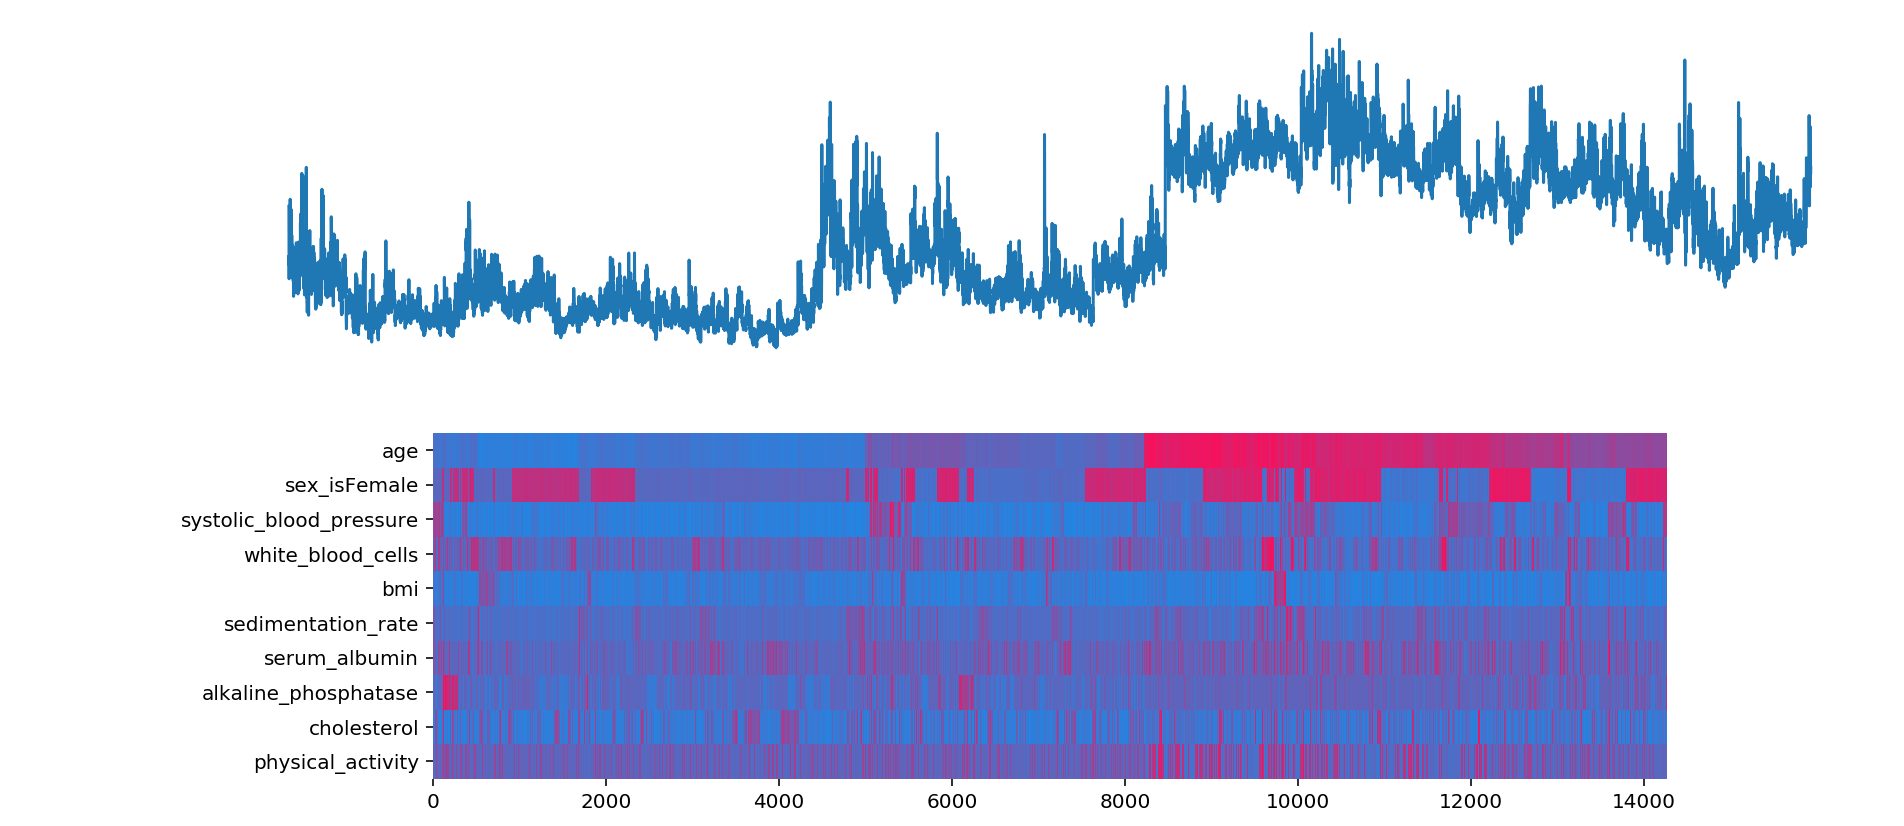

In [43]:
import matplotlib.gridspec as gridspec
np.random.seed(20)
data1 = [np.random.random() for i in range(10)]
data2 = [np.random.random()*1000 for i in range(10)]

gs = gridspec.GridSpec(2,1)
fig = pl.figure(figsize=(15,7))

ax = fig.add_subplot(gs[0])
ax.plot(xgb_shap[clustOrder,:].sum(1))
ax.set_ylabel(r'Label One', size =16)
ax.get_yaxis().set_label_coords(-0.1,0.5)
ax.axis('off')

ax = fig.add_subplot(gs[1])
ax.imshow(xgb_shap_normed[clustOrder,:][:,col_inds].T, aspect=400, cmap=shap.plots.colors.red_blue_solid)
ax.set_yticks(np.arange(len(col_inds)))
ax.set_yticklabels(X.columns[col_inds])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
pl.show()

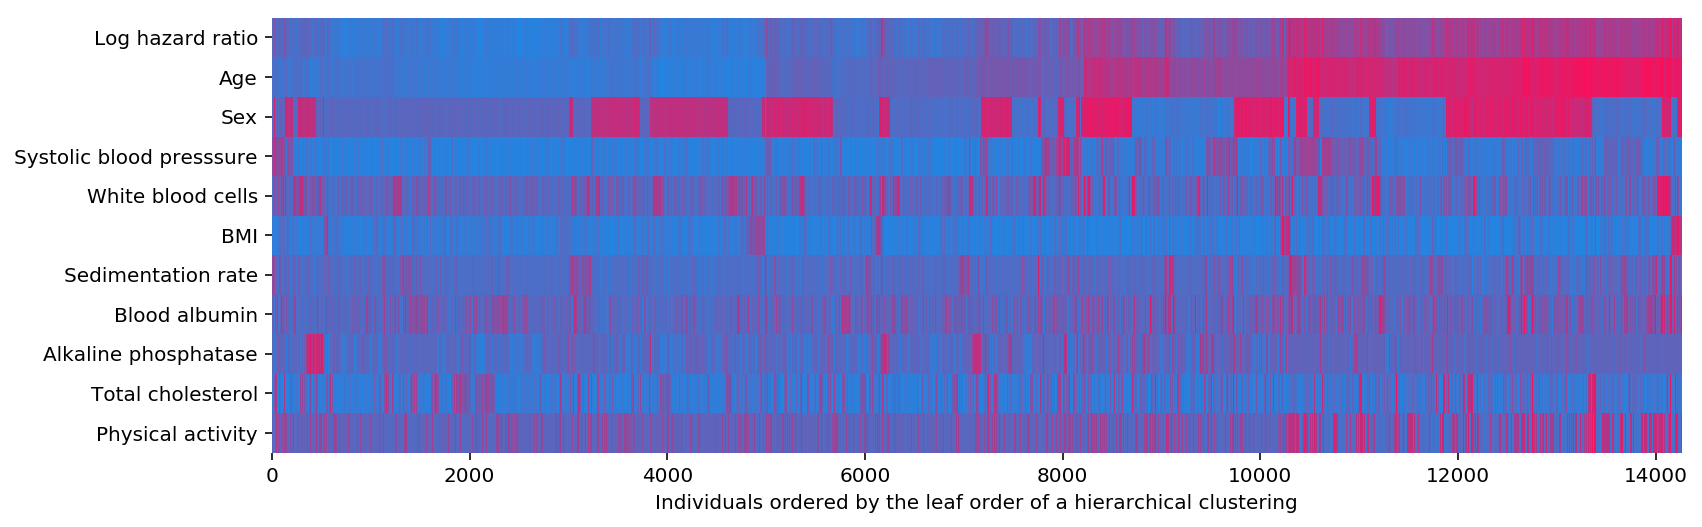

In [276]:
clustOrder = hclust_order(xgb_shap)

col_inds = np.argsort(-np.abs(xgb_shap).mean(0))[:10]

xgb_shap_normed = xgb_shap.copy()
for i in col_inds:
    xgb_shap_normed[:,i] -= xgb_shap_normed[:,i].min()
    xgb_shap_normed[:,i] /= xgb_shap_normed[:,i].max()
    
f = pl.figure(figsize=(15,4))
total = xgb_shap[clustOrder,:].sum(1)
total -= total.min()
total /= total.max()
pl.imshow(np.vstack([total, xgb_shap_normed[clustOrder,:][:,col_inds].T]), aspect=400, cmap=shap.plots.colors.red_blue_solid)
pl.yticks(np.arange(len(col_inds)+1))
pl.gca().set_yticklabels(["Log hazard ratio"] + list(np.array(mapped_feature_names)[col_inds]))
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['left'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['bottom'].set_visible(False)
pl.xlabel("Individuals ordered by the leaf order of a hierarchical clustering")
pl.savefig("raw_figures/nhanes_heatmap.pdf", dpi=400)
pl.show()

In [345]:
rank_order = np.argsort(-np.abs(xgb_shap).mean(0))
tmp = xgb_shap.copy()[:,rank_order[:10]]
tmp += np.random.randn(*tmp.shape)*1e-4
rowOrder = hclust_order(tmp.T, "correlation")
rowOrder = rank_order[rowOrder]

In [346]:
clustOrder = hclust_order(xgb_shap)

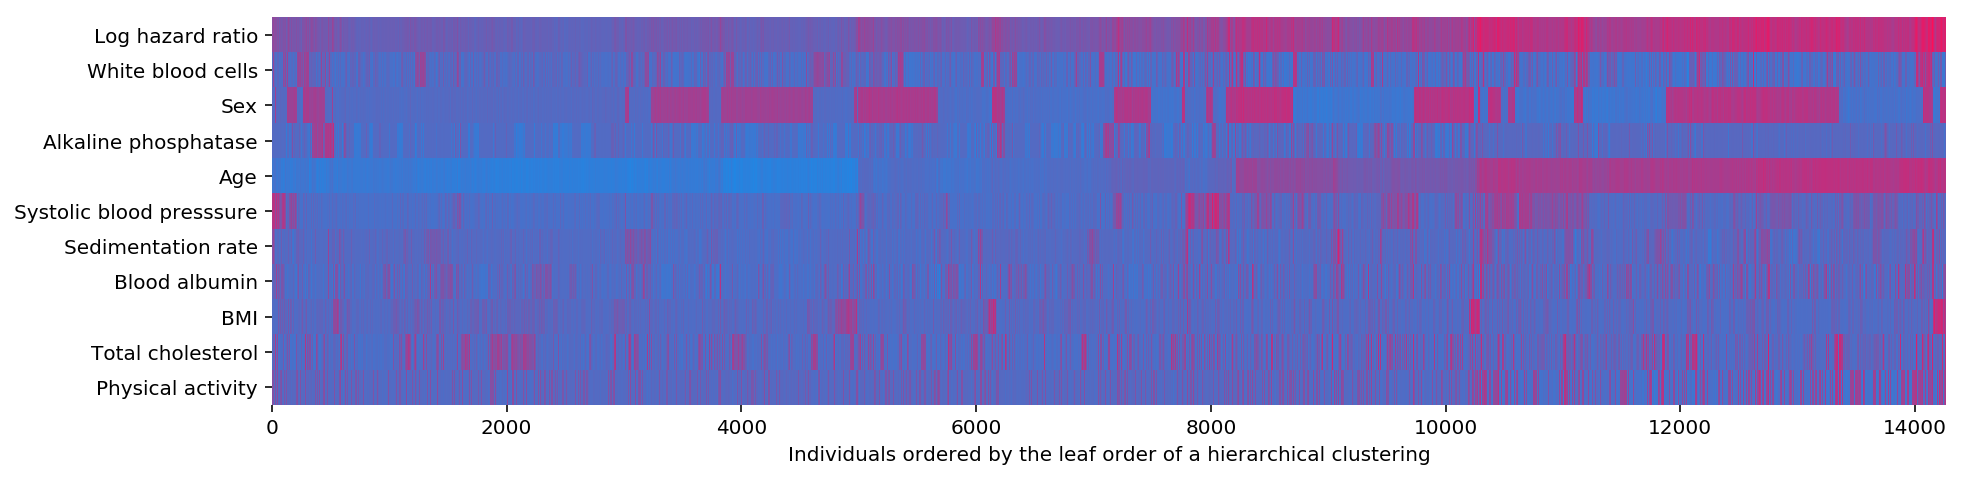

In [347]:
col_inds = rowOrder#np.argsort(-np.abs(xgb_shap).mean(0))[rowOrder]

xgb_shap_normed = xgb_shap.copy()
for i in col_inds:
    pass
    xgb_shap_normed[:,i] -= xgb_shap_normed[:,i].min()
    xgb_shap_normed[:,i] /= xgb_shap_normed[:,i].max()
    xgb_shap_normed[:,i] -= np.median(xgb_shap_normed[:,i])
    
f = pl.figure(figsize=(15,12))
total = xgb_shap[clustOrder,:].sum(1)
total -= total.min()
total /= total.max()
pl.imshow(np.vstack([total, xgb_shap_normed[clustOrder,:][:,col_inds].T]), aspect=300, cmap=shap.plots.colors.red_blue_solid)
pl.yticks(np.arange(len(col_inds)+1))
pl.gca().set_yticklabels(["Log hazard ratio"] + list(np.array(mapped_feature_names)[col_inds]))
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['left'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['bottom'].set_visible(False)
pl.xlabel("Individuals ordered by the leaf order of a hierarchical clustering")
pl.savefig("raw_figures/nhanes_heatmap.pdf", dpi=400)
pl.show()

# Dependence plots

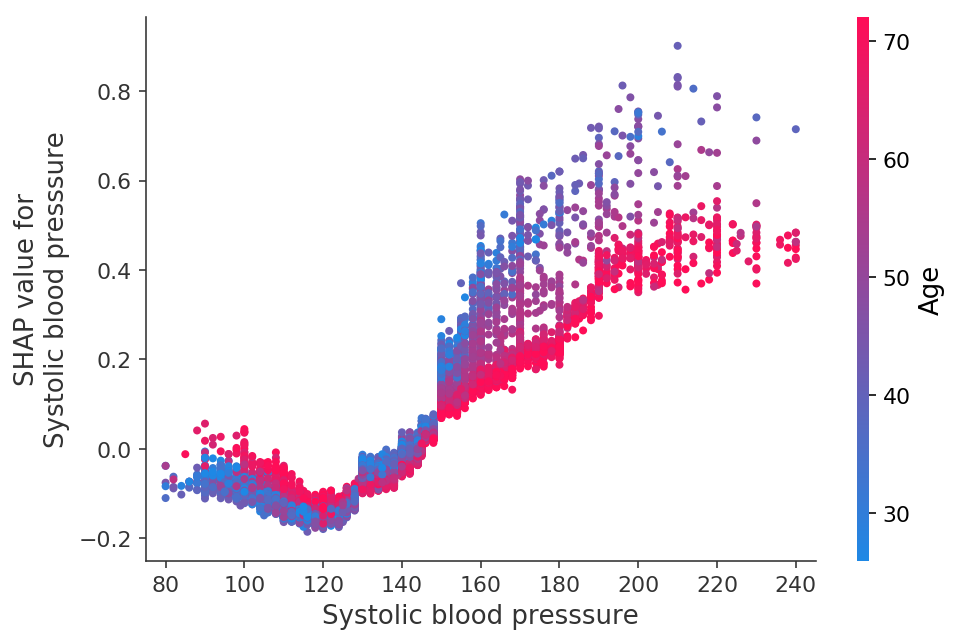

In [40]:
ind = np.where(X.columns == "systolic_blood_pressure")[0][0]
shap.dependence_plot(ind, xgb_shap, X, feature_names=mapped_feature_names, show=False)
pl.xlim(75, 245)
pl.ylim(-0.2,0.9)
pl.savefig("raw_figures/nhanes_dependence_"+X.columns[ind]+".pdf", dpi=400)
pl.show()

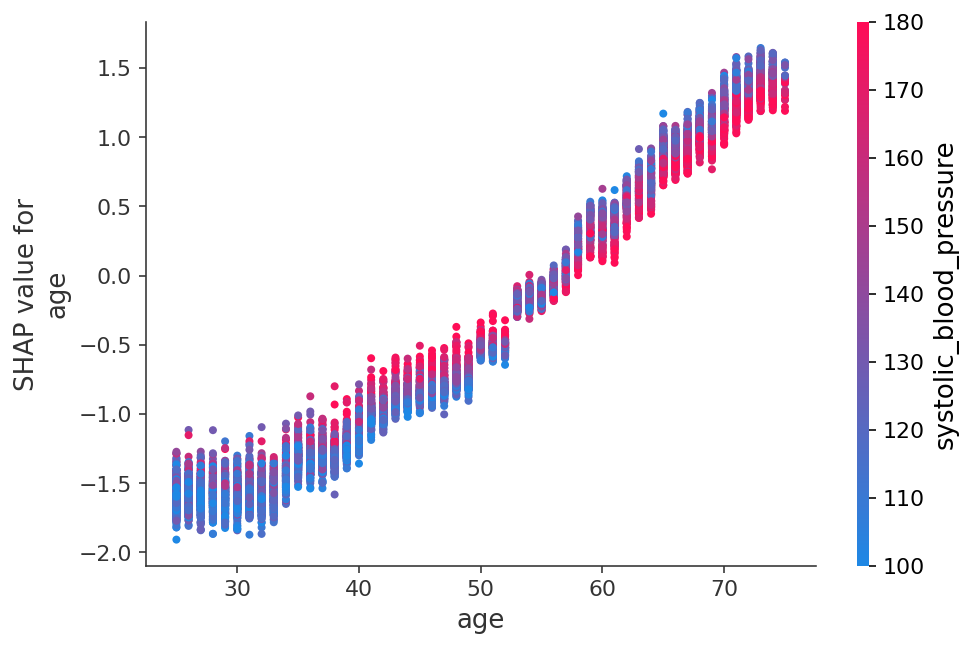

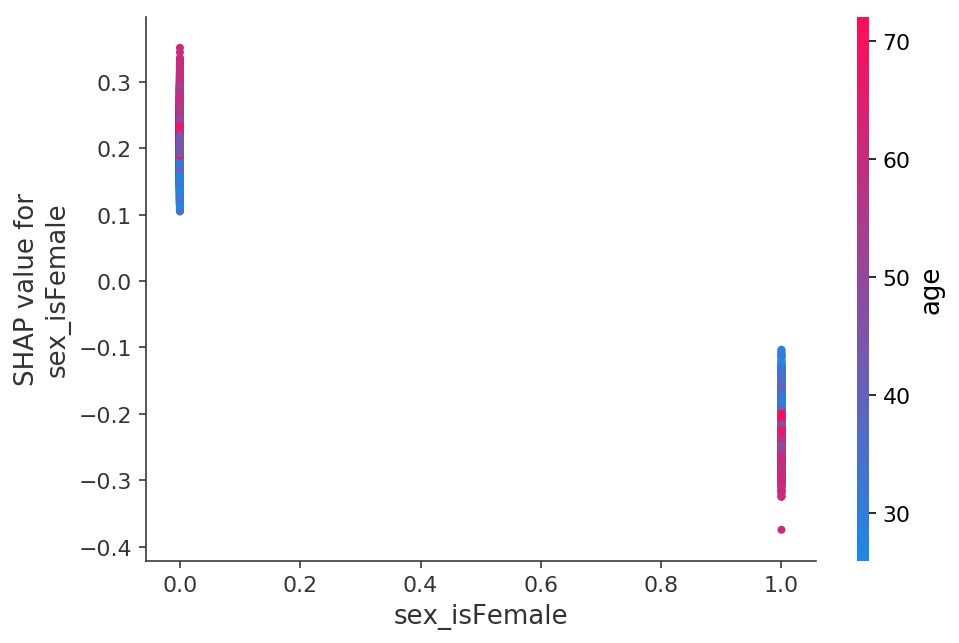

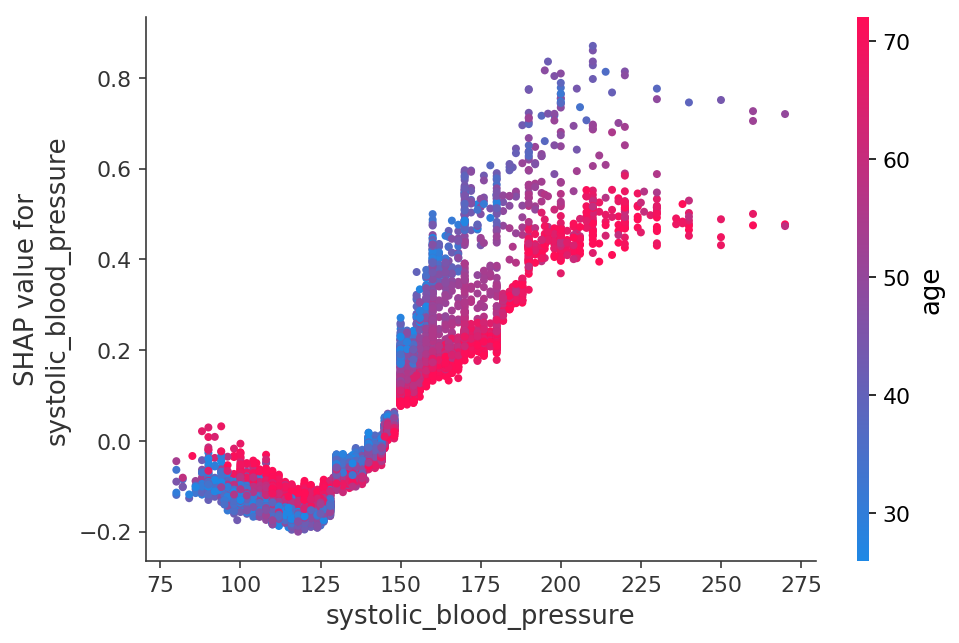

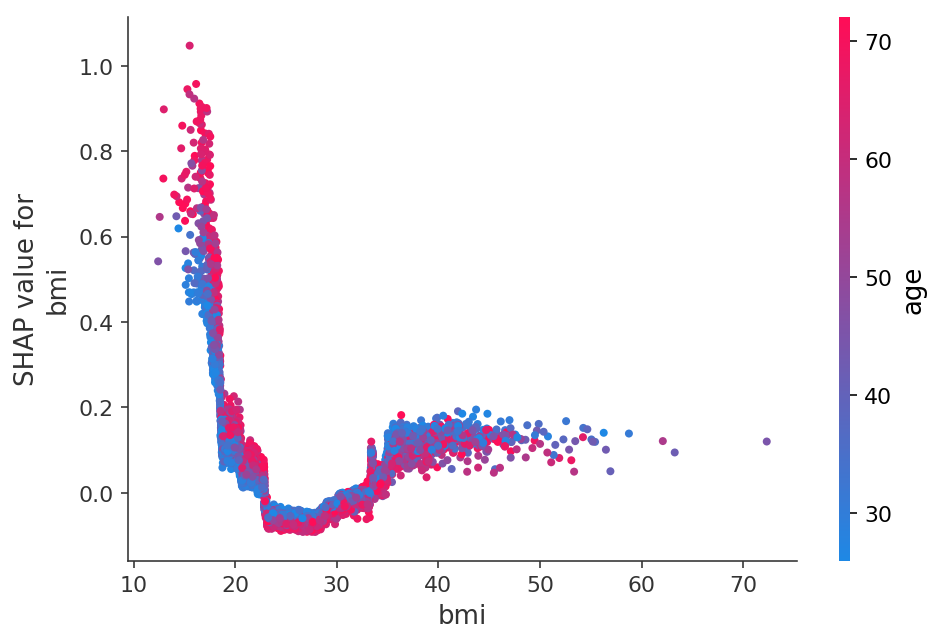

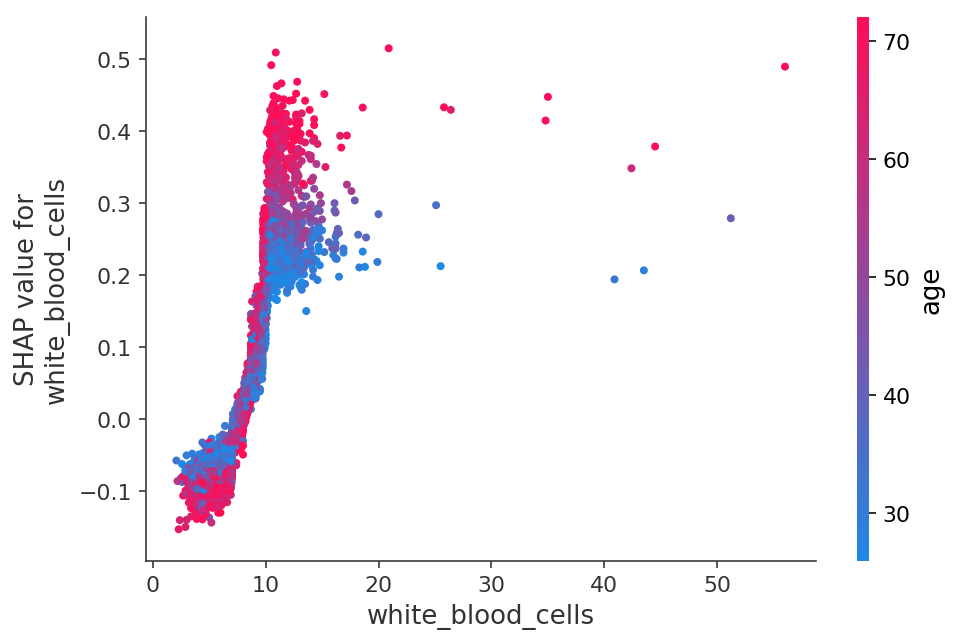

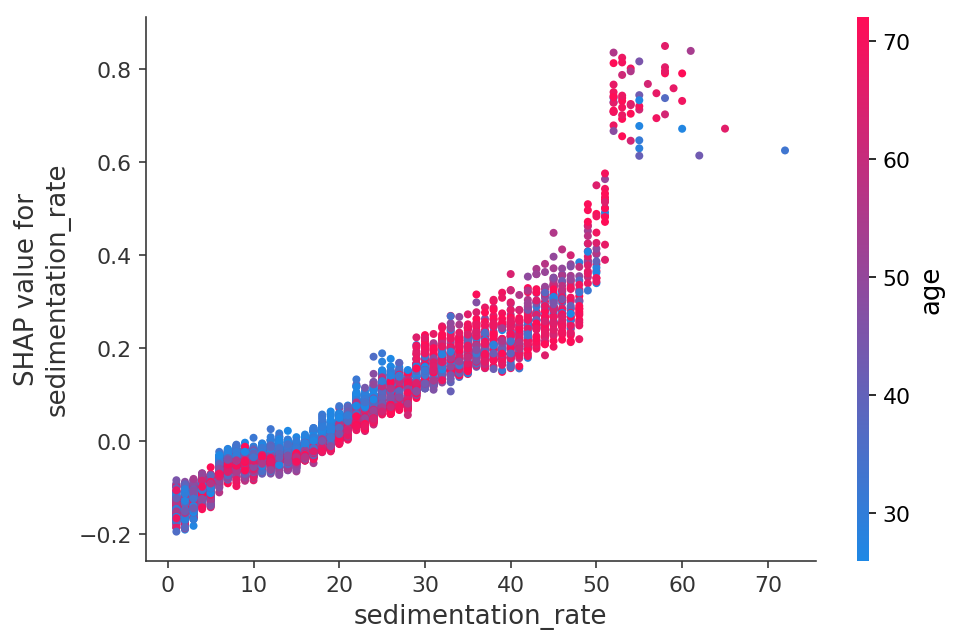

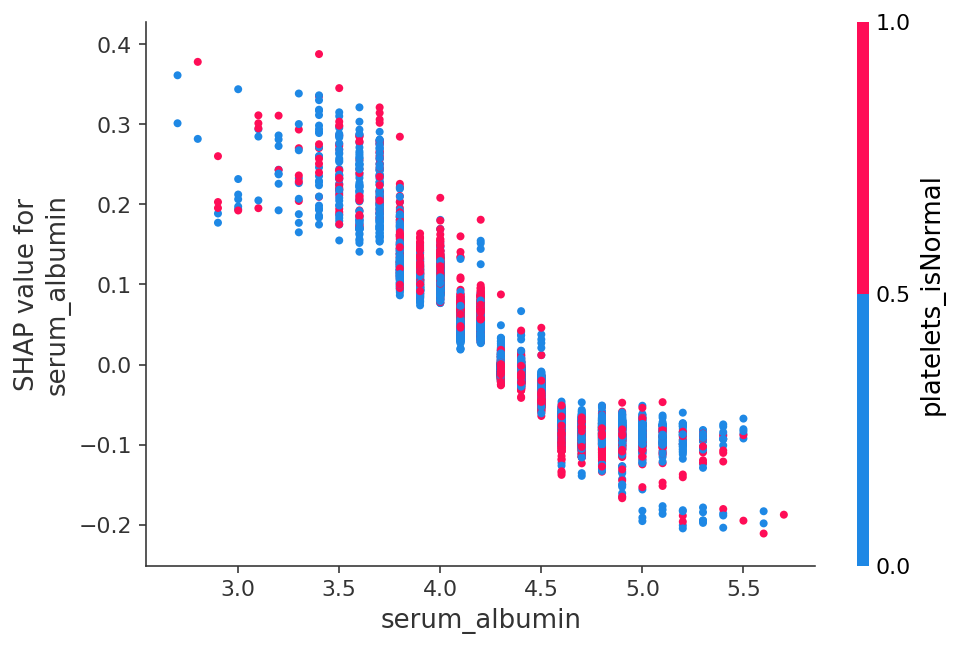

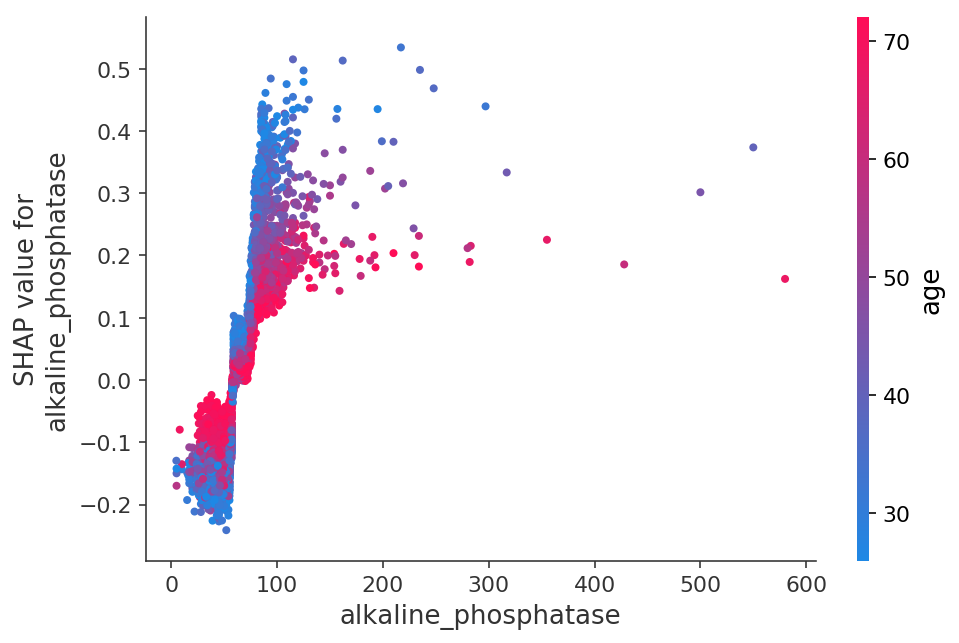

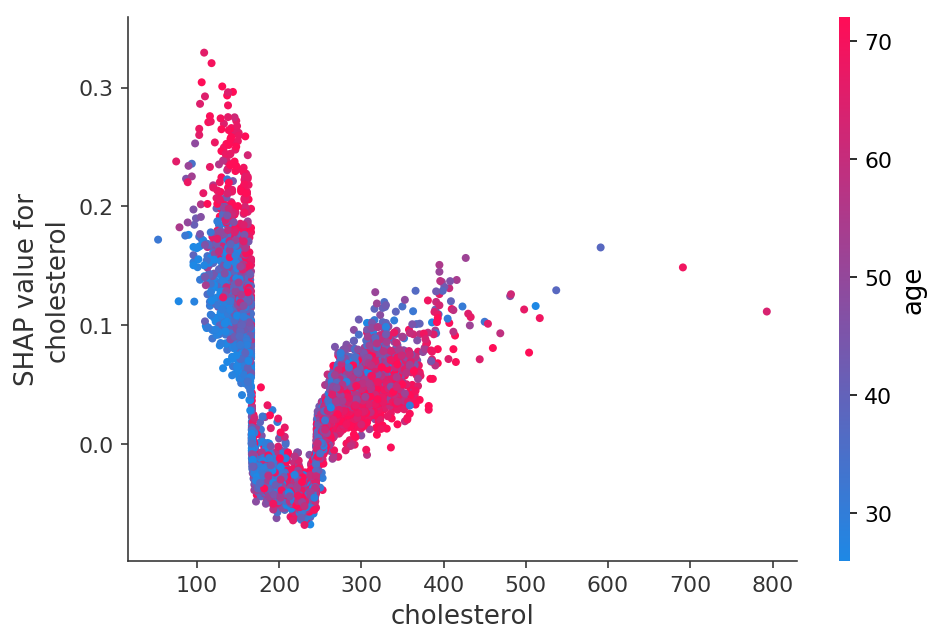

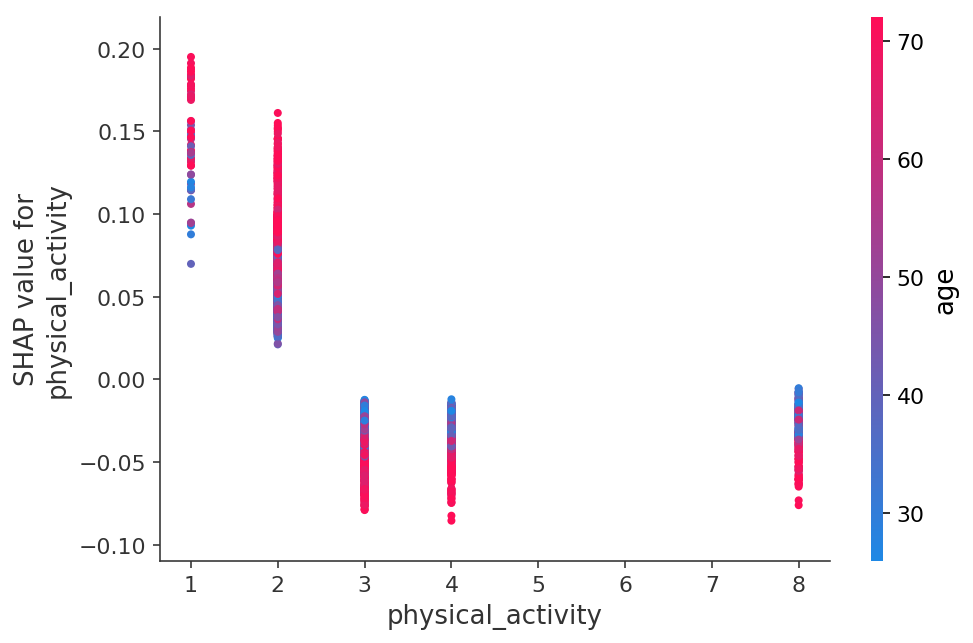

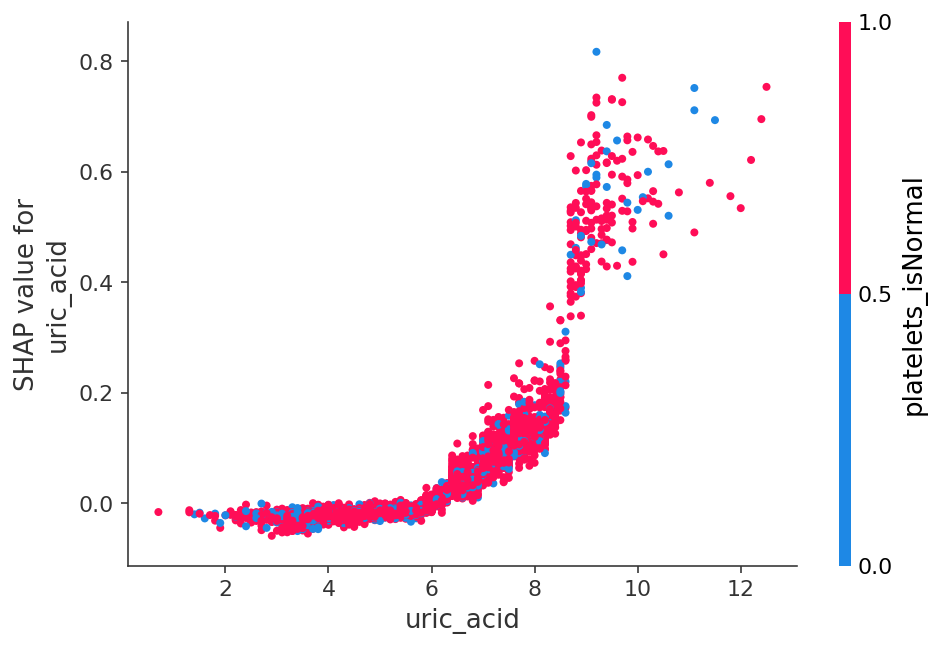

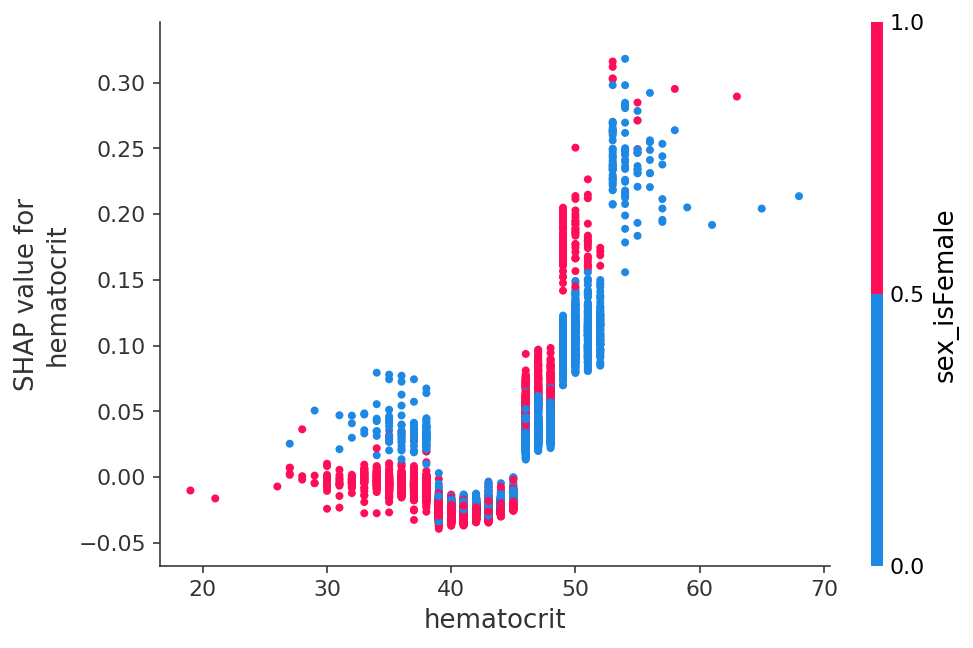

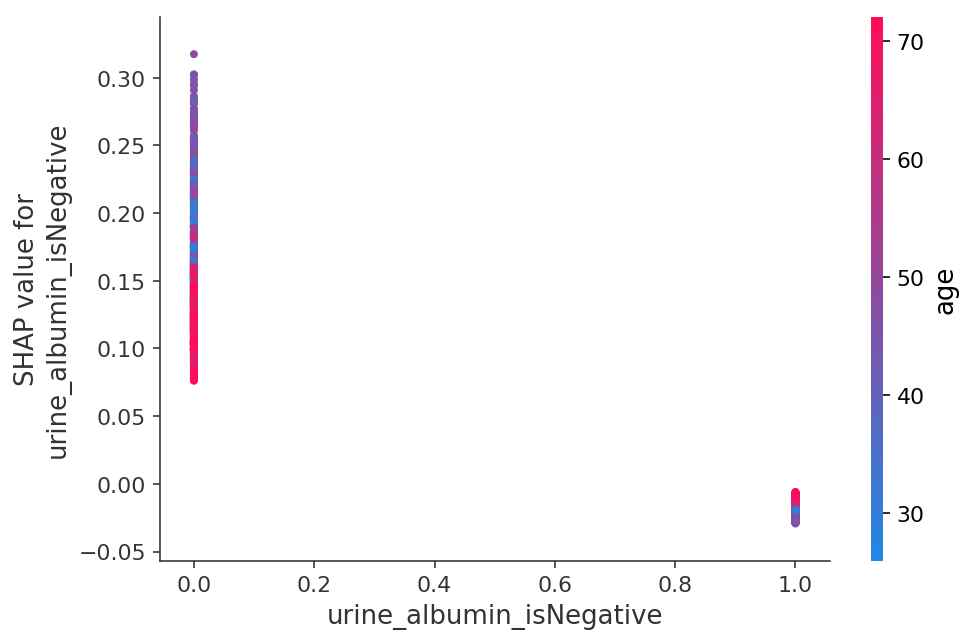

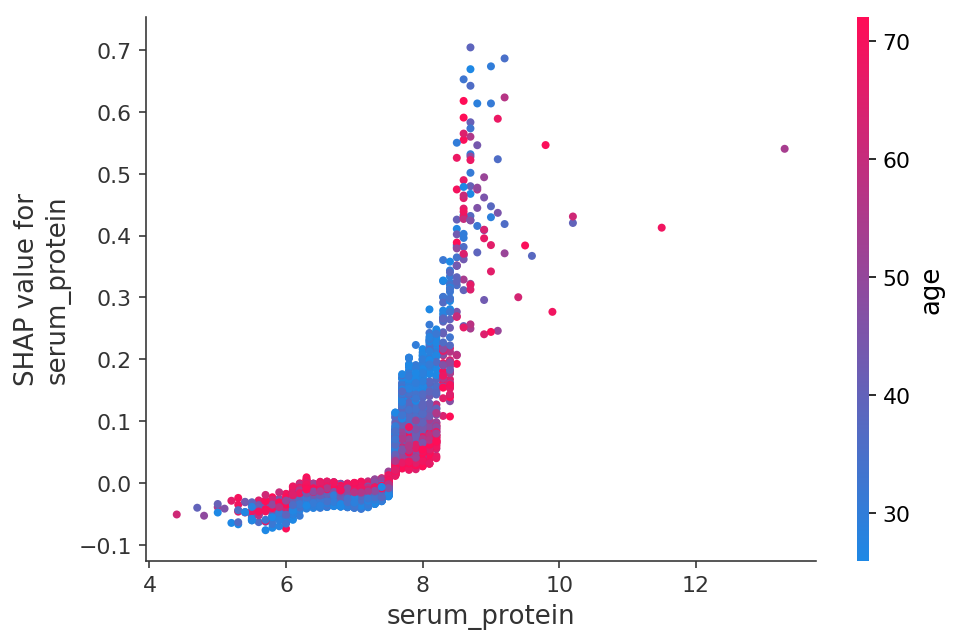

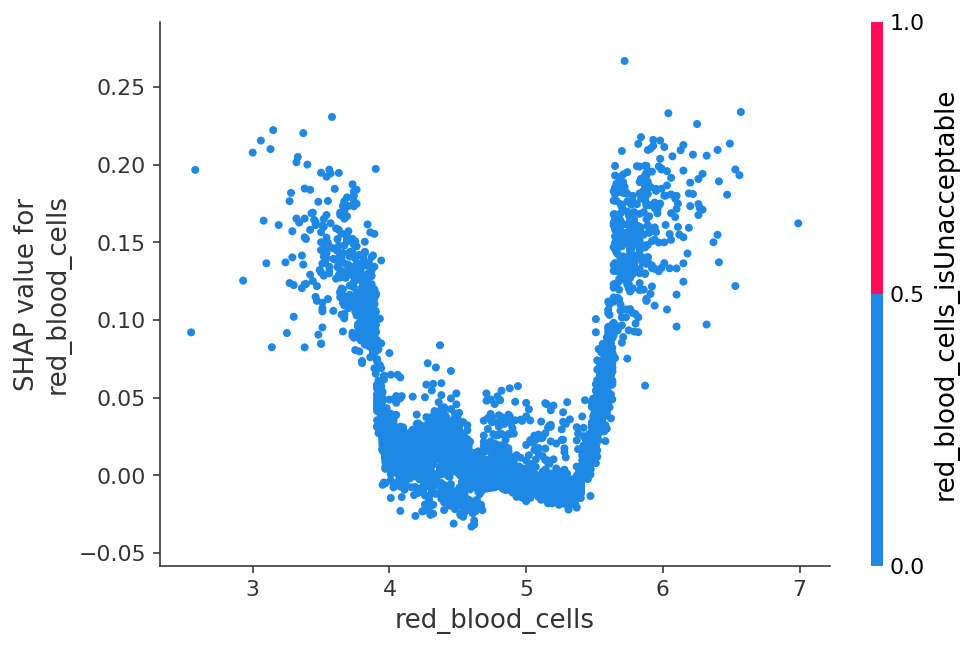

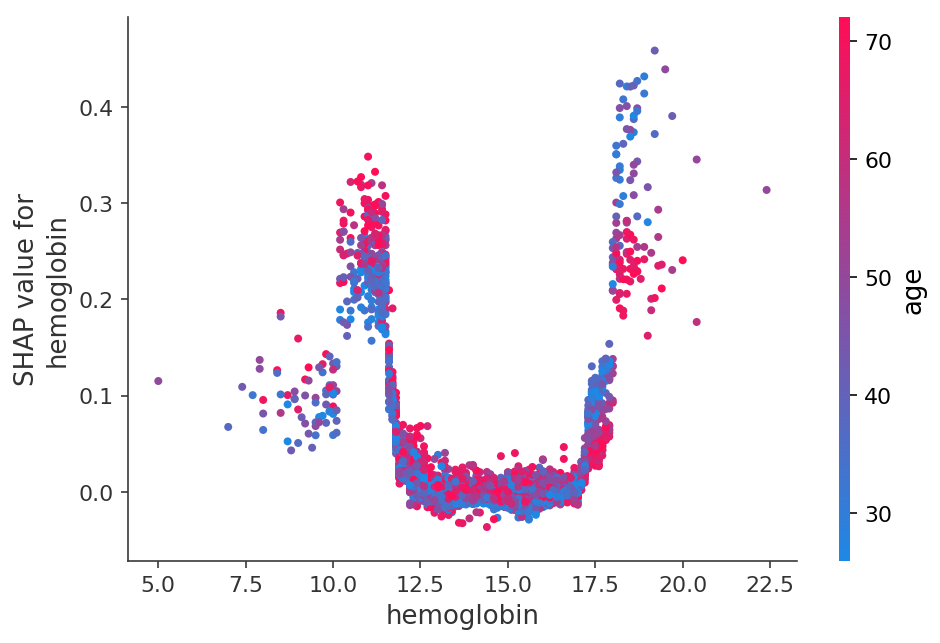

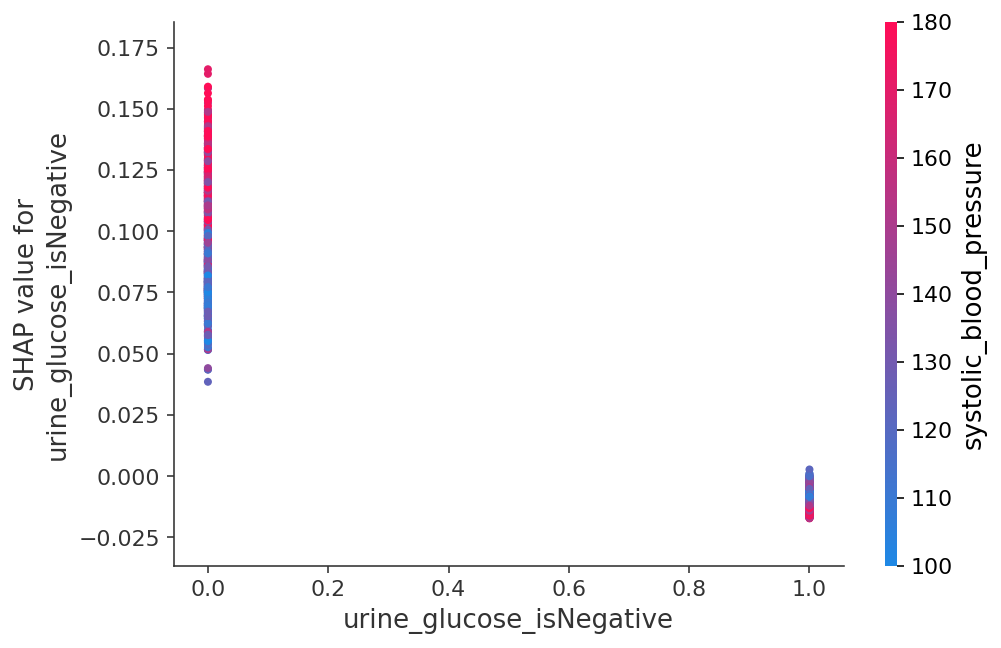

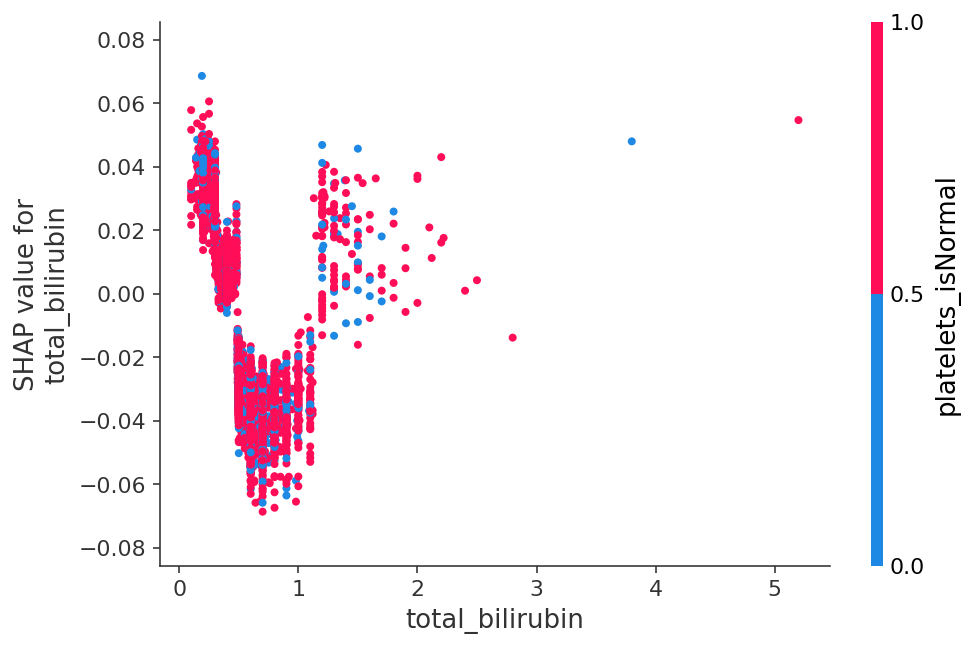

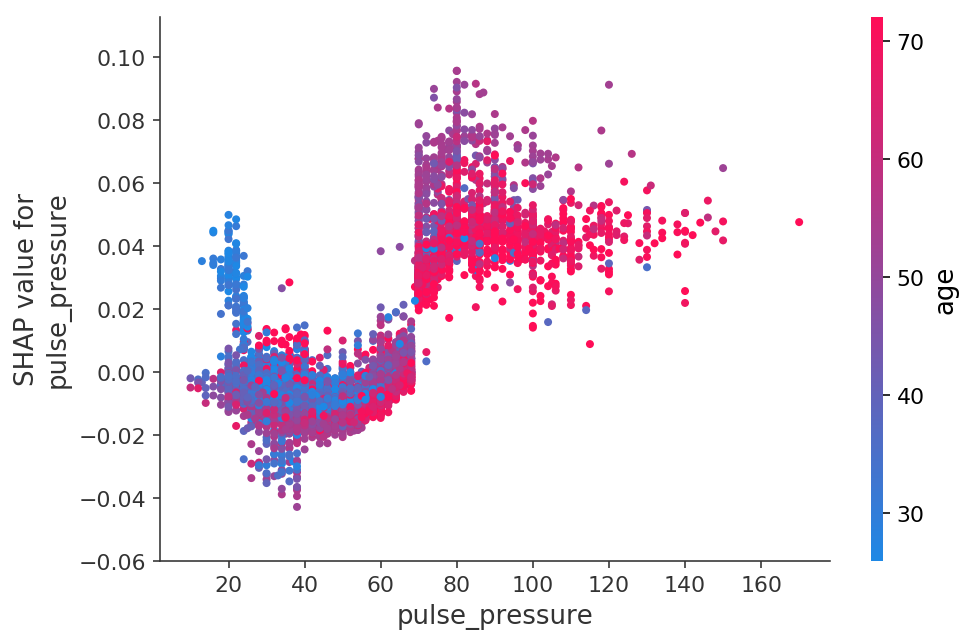

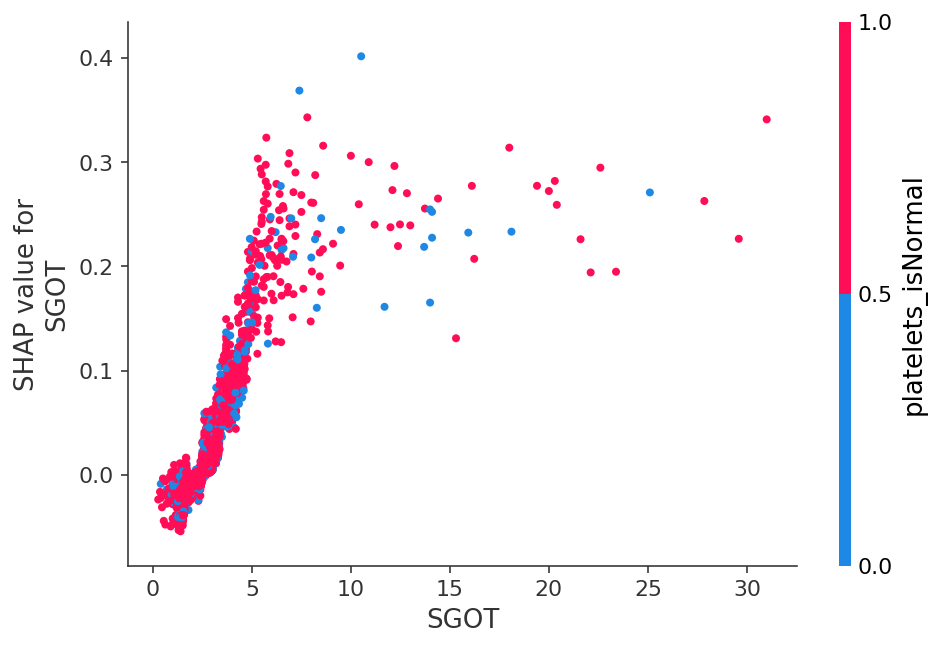

In [27]:
for i in np.argsort(-np.abs(xgb_shap).mean(0))[:20]:
    shap.dependence_plot(i, xgb_shap, X, feature_names=mapped_feature_names, show=False)
    #pl.xlim(np.nanpercentile(X.values[:,i].astype(np.float64), 1), np.nanpercentile(X.values[:,i].astype(np.float64), 99))
    #pl.savefig("raw_figures/kidney_dependence_"+X.columns[i]+".pdf", dpi=400)
    pl.show()

## Make a Partial Dependence Plot

In [122]:
ind1 = np.where(X.columns == "systolic_blood_pressure")[0][0]
ind2 = np.where(X.columns == "age")[0][0]

In [102]:
Xtmp = X.values.copy()

In [126]:
vals1 = np.linspace(80, 240, 20)
vals2 = np.linspace(20, 80, 20)
out = np.zeros((len(vals1), len(vals2)))
for i,v1 in enumerate(vals1):
    Xtmp[:,ind1] = v1
    for j,v2 in enumerate(vals2):
        Xtmp[:,ind2] = v2
        out[i,j] = xgb_model.predict(Xtmp, validate_features=False).mean()

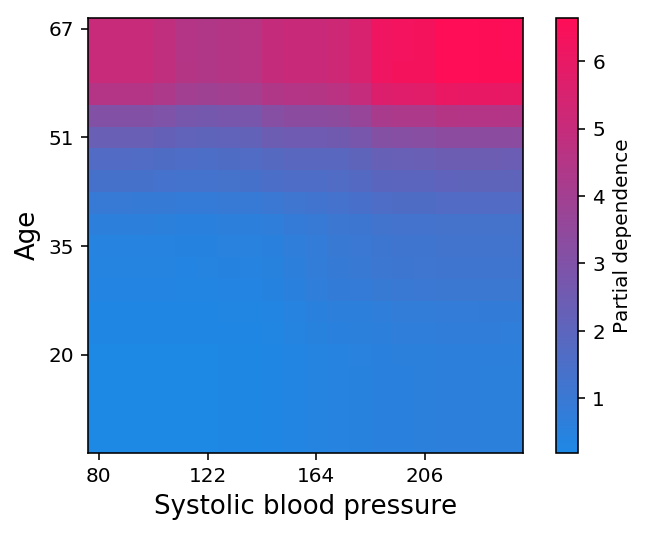

In [157]:
pl.imshow(out.T[list(reversed(np.arange(out.shape[0]))),:], cmap=shap.plots.colors.red_blue_solid)
pl.xticks(range(0,20,5), [int(x) for x in vals1[range(0,20,5)]])
pl.yticks(range(0,20,5), reversed([int(x) for x in vals2[range(0,20,5)]]))
pl.xlabel("Systolic blood pressure", fontsize=13)
pl.ylabel("Age", fontsize=13)
pl.colorbar(label="Partial dependence")
pl.savefig("raw_figures/nhanes_pdp_sbp_age.pdf", dpi=400)
pl.show()

In [110]:
vals = np.linspace(80, 240, 20)
out = np.zeros(len(vals))
for i,v in enumerate(vals):
    Xtmp[:,ind] = v
    out[i] = xgb_model.predict(Xtmp, validate_features=False).mean()

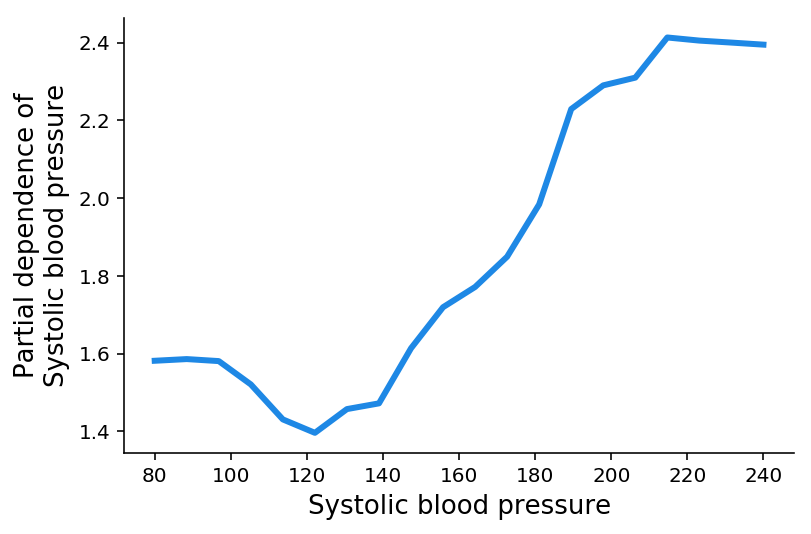

In [120]:
pl.plot(vals, out, color=shap.plots.colors.blue_rgb, linewidth=3)
pl.ylabel("Partial dependence of\nSystolic blood pressure", fontsize=13)
pl.xlabel("Systolic blood pressure", fontsize=13)
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('left')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.savefig("raw_figures/nhanes_pdp_sbp.pdf", dpi=400)
pl.show()

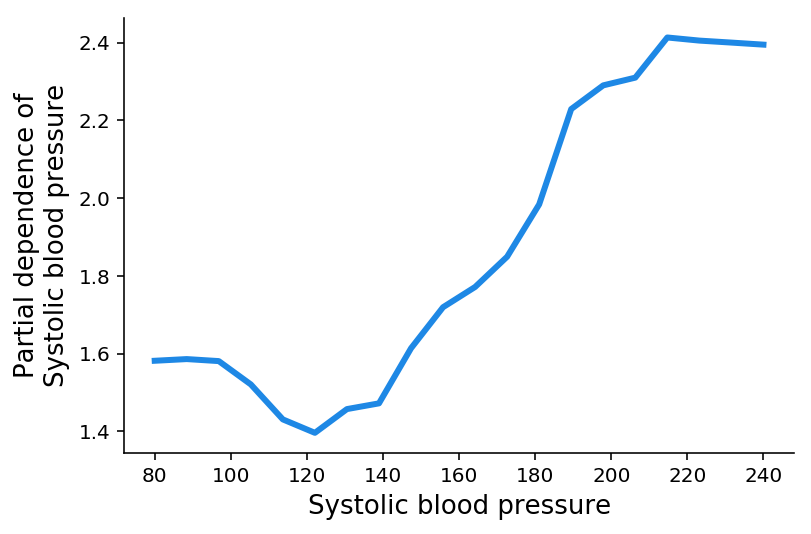

In [120]:
pl.plot(vals, out, color=shap.plots.colors.blue_rgb, linewidth=3)
pl.ylabel("Partial dependence of\nSystolic blood pressure", fontsize=13)
pl.xlabel("Systolic blood pressure", fontsize=13)
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('left')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.savefig("raw_figures/nhanes_pdp_sbp.pdf", dpi=400)
pl.show()